In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [19]:
def load_and_reshape_matrix(name, base_dir, ref_lat=38.10, ref_lon=20.20, dx=0.5, dz=0.5, nx=151, ny=151, nz=151):
    """
    Loads and reshapes a coherence matrix from an .npy file based on the provided parameters.
    
    Parameters:
        name (str): The event name (e.g., 'prlri').
        base_dir (str): The base directory containing the .npy files.
        ref_lat (float): Reference latitude.
        ref_lon (float): Reference longitude.
        dx (float): Grid step in latitude.
        dz (float): Grid step in longitude.
        nx (int): Grid size in x-direction.
        ny (int): Grid size in y-direction.
        nz (int): Grid size in z-direction.
    
    Returns:
        tuple: Reshaped numpy array and calculated latitude/longitude ranges.
    """
    
    # Define file path

    # Define types
    types = ["station", "fibre", "hybrid"]

    file_path = []
    title = []

    # Loop to create paths
    for t in types:
        file_path.append(os.path.join(base_dir, f"{name}_{t}_coherence_matrix.npy"))
        title.append(f"{name} {t} coherence matrix")

    # Convert 50 km to degrees latitude and longitude
    km_to_deg = (nx * dx) / np.sqrt(2) / 111
    km_to_deg_lon = (nx * dx) / np.sqrt(2) / (111 * math.cos(math.radians(ref_lat)))
    
    # Compute lat/lon range
    lat_range = (ref_lat, ref_lat + km_to_deg)
    lon_range = (ref_lon, ref_lon + km_to_deg_lon)
    


    return file_path, title, lat_range, lon_range

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
import matplotlib.colors as mcolors
import pandas as pd

def cartesian_to_geographic(x, y, origin_lat, origin_lon):
    earth_radius = 6371  # Approximate Earth radius in km
    lat = origin_lat + (y / earth_radius) * (180 / np.pi)
    lon = origin_lon + (x / (earth_radius * np.cos(np.radians(origin_lat)))) * (180 / np.pi)
    return lat, lon

def load_das_channels(csv_file):
    df = pd.read_csv(csv_file)
    das_channels = {row['channel_number_recorded']: (row['latitude'], row['longitude']) for _, row in df.iterrows()}
    return das_channels

def plot_geographical_map(ref_lat, ref_lon, stations, das_csv, das_hyb, earthquake_location, corrmatrix_sta, 
                          cartesian_grid_x, cartesian_grid_y, lat_range, lon_range, files, titles, 
                          title="Geographical Map with Correlation"):
    
    das = load_das_channels(das_csv)
    file_dir = os.path.dirname(files)
    
    # Ensure correct matrix shape
    nx, ny, nz = np.shape(corrmatrix_sta)
    CXY = np.zeros([ny, nx])
    for i in range(ny):
        for j in range(nx):
            CXY[i, j] = np.max(corrmatrix_sta[j, i, :])  # Ensure proper indexing
    
    # Normalize coherence matrix
    CXY_normalized = (CXY - np.min(CXY)) / (np.max(CXY) - np.min(CXY))
    
    # Convert Cartesian grid to geographic coordinates
    lat_grid, lon_grid = cartesian_to_geographic(cartesian_grid_x, cartesian_grid_y, ref_lat, ref_lon)
    
    # Ensure proper latitude and longitude alignment
    lat_lin = np.linspace(lat_range[0], lat_range[1], ny)
    lon_lin = np.linspace(lon_range[0], lon_range[1], nx)
    grid_lon, grid_lat = np.meshgrid(lon_lin, lat_lin)
    interpolated_CXY = griddata((lat_grid.flatten(), lon_grid.flatten()), CXY_normalized.flatten(), (grid_lat, grid_lon), method='cubic')
    
    # Find the maximum coherence location correctly
    max_index = np.unravel_index(np.argmax(interpolated_CXY, axis=None), interpolated_CXY.shape)
    max_lat = grid_lat[max_index]
    max_lon = grid_lon[max_index]
    # Manually define Viridis-inspired RGB colors

    # Original RGB colors from the Viridis palette
    viridis_rgb = [
        [68, 1, 84],
        [71, 35, 122],
        [59, 81, 139],
        [44, 121, 153],
        [33, 145, 140],
        [45, 174, 109],
        [96, 186, 59],
        [189, 196, 36],
        [253, 231, 37]
    ]

    # Normalize the RGB values to the range [0, 1]
    viridis_rgb = np.array(viridis_rgb) / 255.0

    # Create a colormap from the original colors
    viridis_cmap = mcolors.ListedColormap(viridis_rgb)

    # Generate 20 evenly spaced levels by interpolating the colors
    new_levels = 20
    new_colors = viridis_cmap(np.linspace(0, 1, new_levels))
    # Create a colormap from the defined RGB colors
    cmap = mcolors.ListedColormap(new_colors)
    
    # Create a norm for specific value boundaries to assign colors properly
    boundaries = np.linspace(0, 1, 21)  # 20 levels from 0 to 1
    norm = mcolors.BoundaryNorm(boundaries, cmap.N)
    
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 15), dpi=400)
    
    # Basemap
    m = Basemap(projection='cyl', llcrnrlat=lat_range[0], urcrnrlat=lat_range[1],
                llcrnrlon=lon_range[0], urcrnrlon=lon_range[1], resolution='h', ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawrivers(color='blue', linewidth=0.5)
    m.fillcontinents(color='lightgray', lake_color='lightblue')
    m.drawmapboundary(fill_color='lightblue')
    
    # Plot interpolated coherence with custom colormap and norm
    cs = ax.contourf(grid_lon, grid_lat, interpolated_CXY, 30, cmap=cmap, norm=norm, alpha=0.8)
    
    # Plot DAS channels
    channel_numbers = np.array(list(das.keys()))
    das_colors = cm.Reds(np.linspace(0.3, 1, len(das)))
    das_items = list(das.items())
    for idx in range(0, len(das_items), 100):  # Plot every 100th channel
        channel, (lat, lon) = das_items[idx]
        plt.scatter(lon, lat, marker='o', color=das_colors[idx], s=50)
    
    # Add grid lines
    ax.grid(True, linestyle='--', linewidth=0.5)
    
    # Plot earthquake location
    plt.scatter(earthquake_location[1], earthquake_location[0], marker='*', color='red', edgecolors='black', s=120, label='Catalog Location')
    
    # Plot maximum coherence location
    plt.scatter(max_lon, max_lat, marker='*', color='yellow', edgecolors='black', s=150, label='Max Coherence')
    
    # Plot stations
    stations_colors = cm.Reds(np.linspace(0.3, 1, len(stations)))
    for idx, (key, (lat, lon)) in enumerate(stations.items()):
        plt.scatter(lon, lat, marker='^', color=stations_colors[idx], edgecolors='black', s=200, label=key)
    
    # Plot hybrid DAS stations
    das_hyb_colors = cm.Reds(np.linspace(0.3, 1, len(das_hyb)))
    for idx, (key, (lat, lon)) in enumerate(das_hyb.items()):
        plt.scatter(lon, lat, marker='o', color=das_hyb_colors[idx], edgecolors='black', s=80, label=key)
    
    # Colorbars
    cbar1 = fig.colorbar(cs, ax=ax, orientation='vertical', fraction=0.026, pad=0.11, shrink=0.8)
    cbar1.set_label('Coherence', fontsize=8)
    
    das_norm = mcolors.Normalize(vmin=min(channel_numbers), vmax=max(channel_numbers))
    sm = plt.cm.ScalarMappable(cmap=cm.Reds, norm=das_norm)  # Use Viridis or another distinct colormap
    sm.set_array([])
    cbar2 = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.05, shrink=0.8)
    cbar2.set_label('DAS Channel ID', fontsize=8)
    
    plt.legend(loc='lower left', fontsize=8)
    plt.xticks(np.linspace(lon_range[0], lon_range[1], num=6))
    plt.yticks(np.linspace(lat_range[0], lat_range[1], num=6))
    
    plt.xlabel("Longitude", fontsize=10)
    plt.ylabel("Latitude", fontsize=10)
    plt.title(title, fontsize=14, fontweight='bold')
    
    # Save figure
    pdf_filename = os.path.join(file_dir, titles + ".pdf")
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
    plt.show()


In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata

def load_das_channels(csv_file):
    df = pd.read_csv(csv_file)
    das_channels = {row['channel_number_recorded']: (row['latitude'], row['longitude']) for _, row in df.iterrows()}
    return das_channels

def plot_geographical_map_simple(ref_lat, ref_lon, stations, das_csv, earthquake_location, corrmatrix_sta, 
                                 cartesian_grid_x, cartesian_grid_y, lat_range, lon_range, files, titles, 
                                 title="Geographical Map with Correlation"):
    file_dir = os.path.dirname(files)
    
    das = load_das_channels(das_csv)
    
    nx, ny, nz = np.shape(corrmatrix_sta)
    CXY = np.zeros([ny, nx])
    for i in range(ny):
        for j in range(nx):
            CXY[i, j] = np.max(corrmatrix_sta[j, i, :])

    # Normalize CXY to range between 0 and 1
    CXY_normalized = (CXY - np.min(CXY)) / (np.max(CXY) - np.min(CXY))
    
    origin_lat, origin_lon = ref_lat, ref_lon
    
    lat_grid, lon_grid = cartesian_to_geographic(cartesian_grid_x, cartesian_grid_y, origin_lat, origin_lon)
    
    lat_lin = np.linspace(lat_range[0], lat_range[1], ny)
    lon_lin = np.linspace(lon_range[0], lon_range[1], nx)
    grid_lat, grid_lon = np.meshgrid(lat_lin, lon_lin)
    interpolated_CXY = griddata((lat_grid.flatten(), lon_grid.flatten()), CXY_normalized.flatten(), (grid_lat, grid_lon), method='cubic')
    
    # Find the location of the maximum value
    max_idx = np.unravel_index(np.argmax(interpolated_CXY, axis=None), interpolated_CXY.shape)
    max_lat, max_lon = grid_lat[max_idx], grid_lon[max_idx]

    fig, ax = plt.subplots(figsize=(10, 12), dpi=400)
    m = Basemap(projection='cyl', llcrnrlat=lat_range[0], urcrnrlat=lat_range[1],
                llcrnrlon=lon_range[0], urcrnrlon=lon_range[1], resolution='h', ax=ax)

    m.drawcoastlines()
    m.drawcountries()
    m.drawrivers(color='blue', linewidth=0.5)
    m.fillcontinents(color='lightgray', lake_color='lightblue')
    m.drawmapboundary(fill_color='lightblue')

    # Plot normalized coherence matrix
    cs = ax.contourf(grid_lon, grid_lat, interpolated_CXY, 30, cmap='viridis', alpha=0.8)
    
    # Colorbar
    cbar = plt.colorbar(cs, ax=ax, label='Normalized Coherence', location='bottom', pad=0.08, fraction=0.02)
    cbar.ax.tick_params(labelsize=8)
    
    # Plot DAS channels with colorbar
    channel_numbers = np.array(list(das.keys()))
    norm = plt.Normalize(vmin=np.min(channel_numbers), vmax=np.max(channel_numbers))
    das_colors = cm.BuGn(norm(channel_numbers))
    
    for idx, (channel, (lat, lon)) in enumerate(das.items()):
        plt.scatter(lon, lat, marker='o', color=das_colors[idx],  s=50)

    sm = plt.cm.ScalarMappable(cmap=cm.BuGn, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='DAS Channel ID', location='right', fraction=0.02, pad=0.04) 
    cbar.ax.tick_params(labelsize=8)


    # Plot stations
    stations_colors = cm.Blues(np.linspace(0.3, 1, len(stations)))
    for idx, (key, (lat, lon)) in enumerate(stations.items()):
        plt.scatter(lon, lat, marker='^', color=stations_colors[idx], edgecolors='black', s=80, label=key)
    
    # Add legend for stations
    plt.legend(loc='upper right', fontsize=8, title='Stations')
    
    plt.xticks(np.linspace(lon_range[0], lon_range[1], num=6))
    plt.yticks(np.linspace(lat_range[0], lat_range[1], num=6))
    
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title, fontsize=14, fontweight='bold')
    
    # Save the plot
    pdf_filename = os.path.join(file_dir, titles + ".pdf")
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
    
    plt.show()


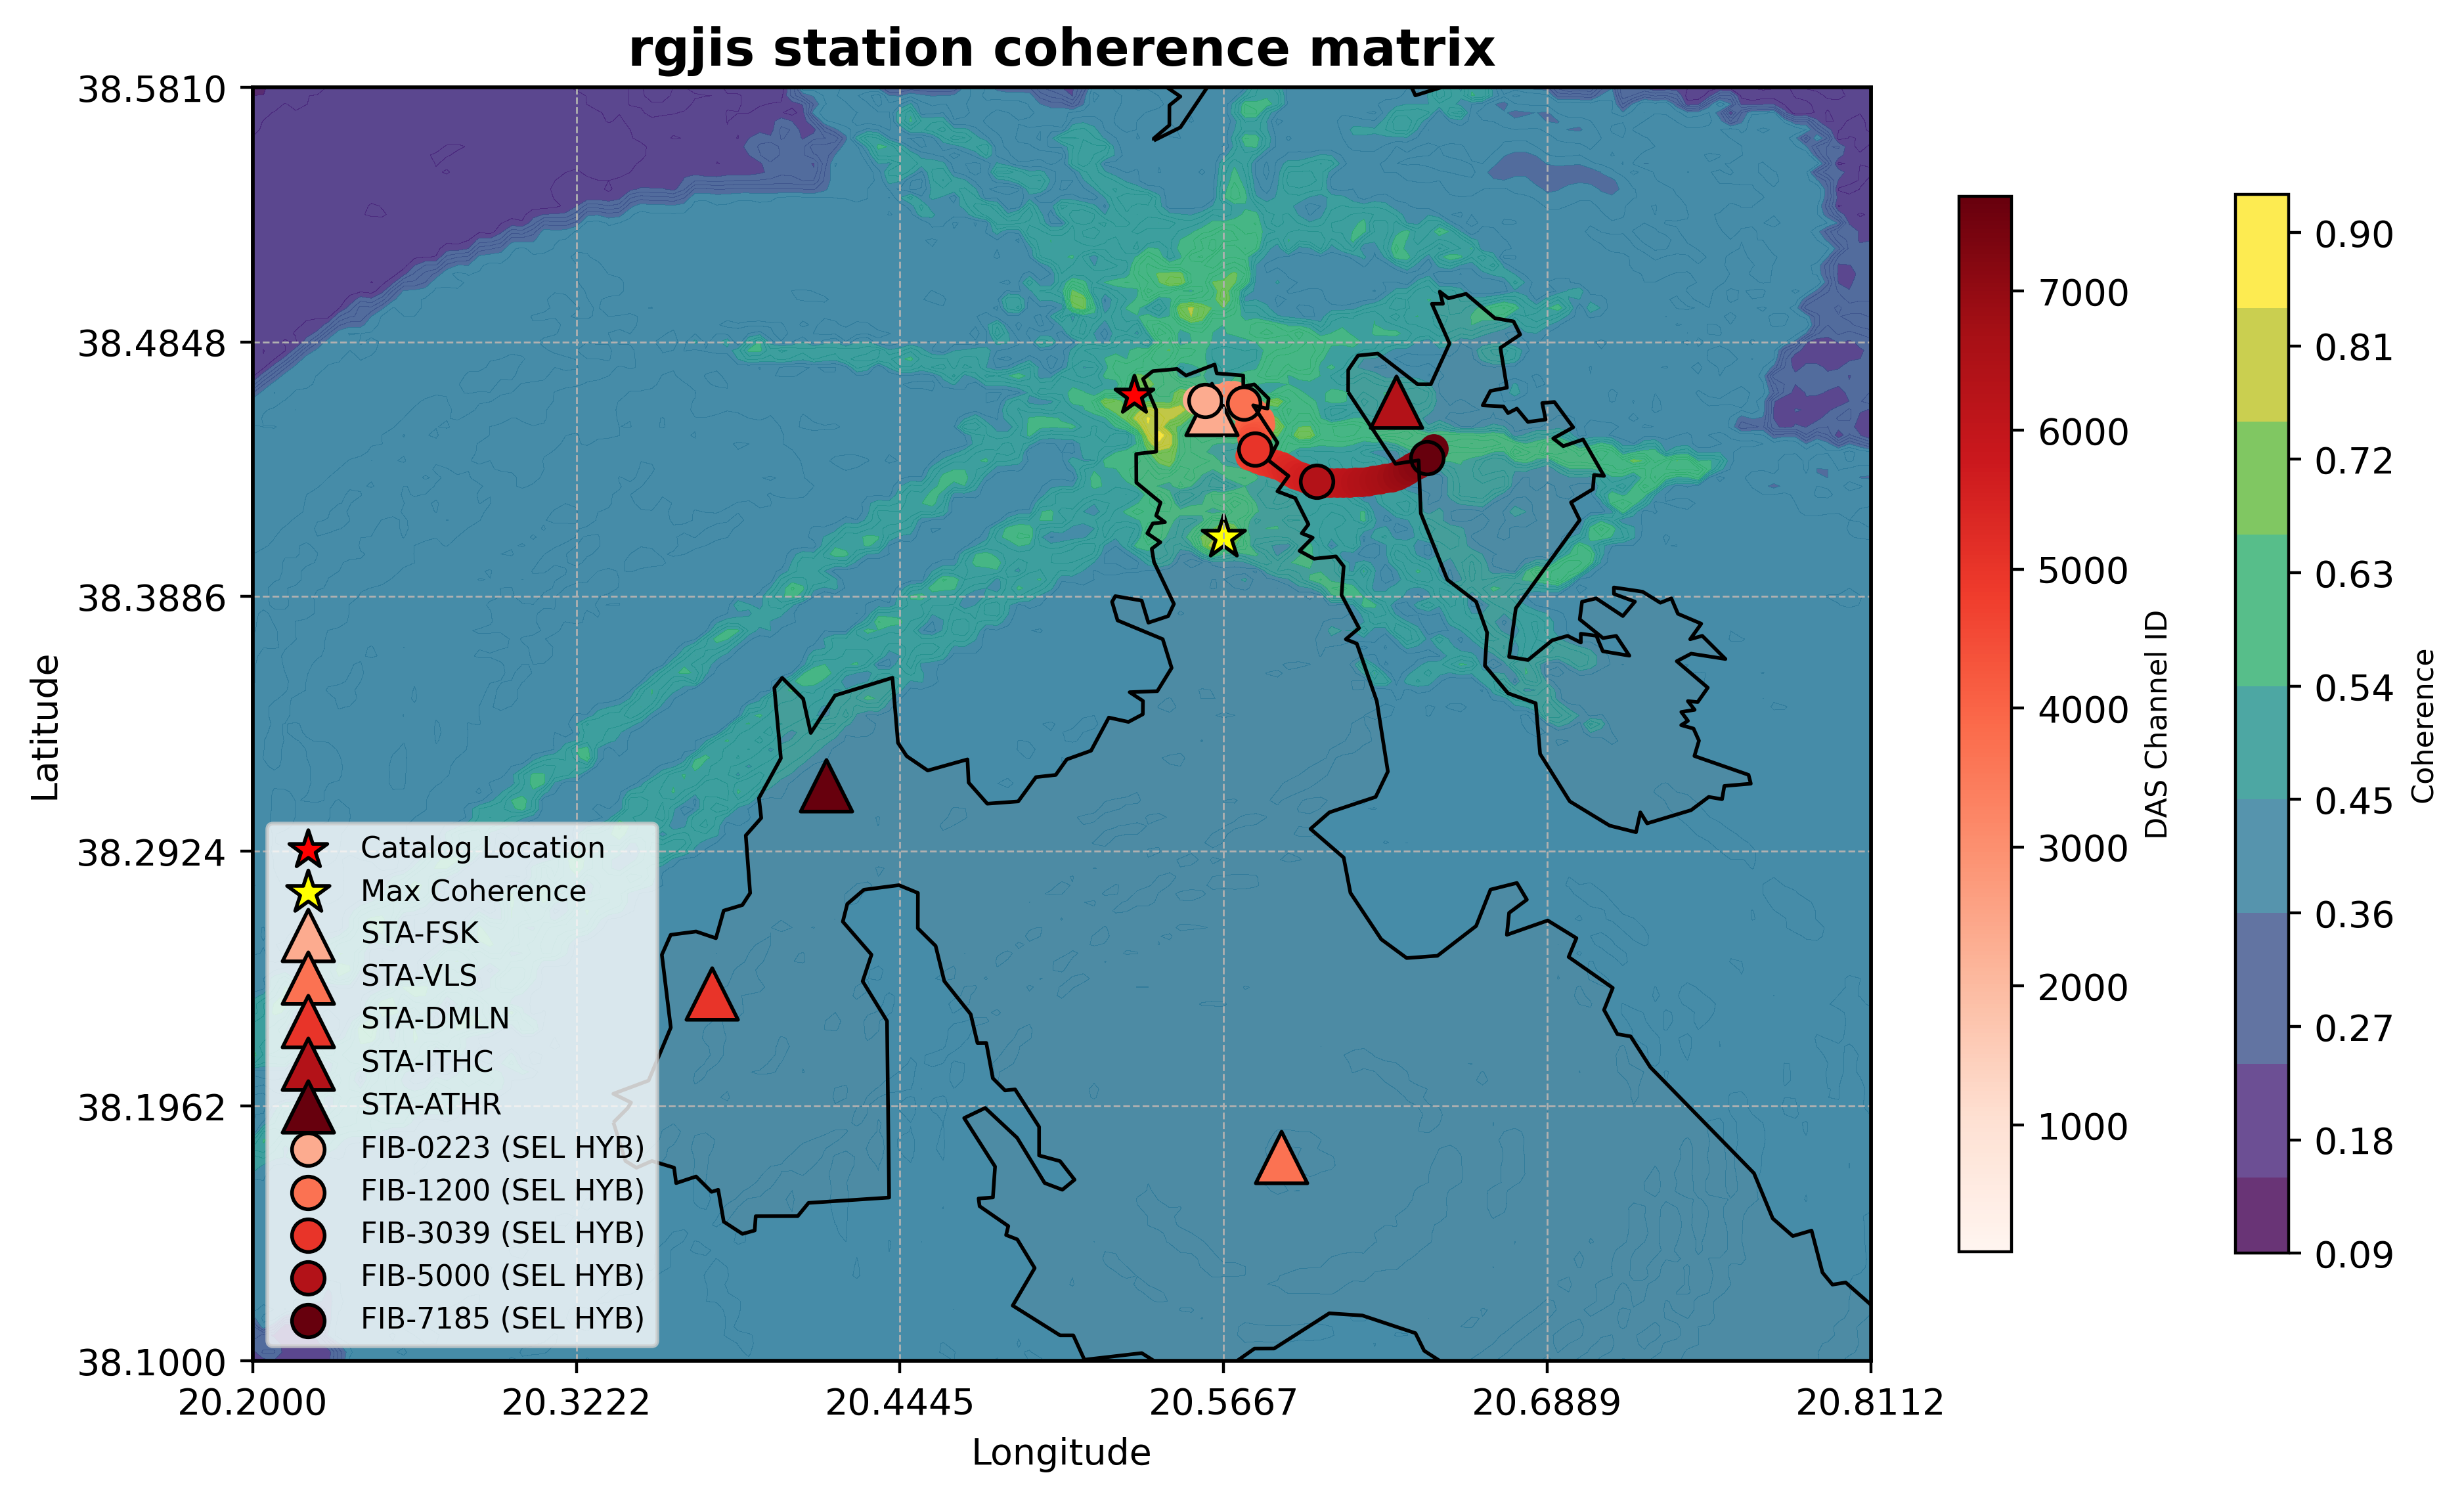

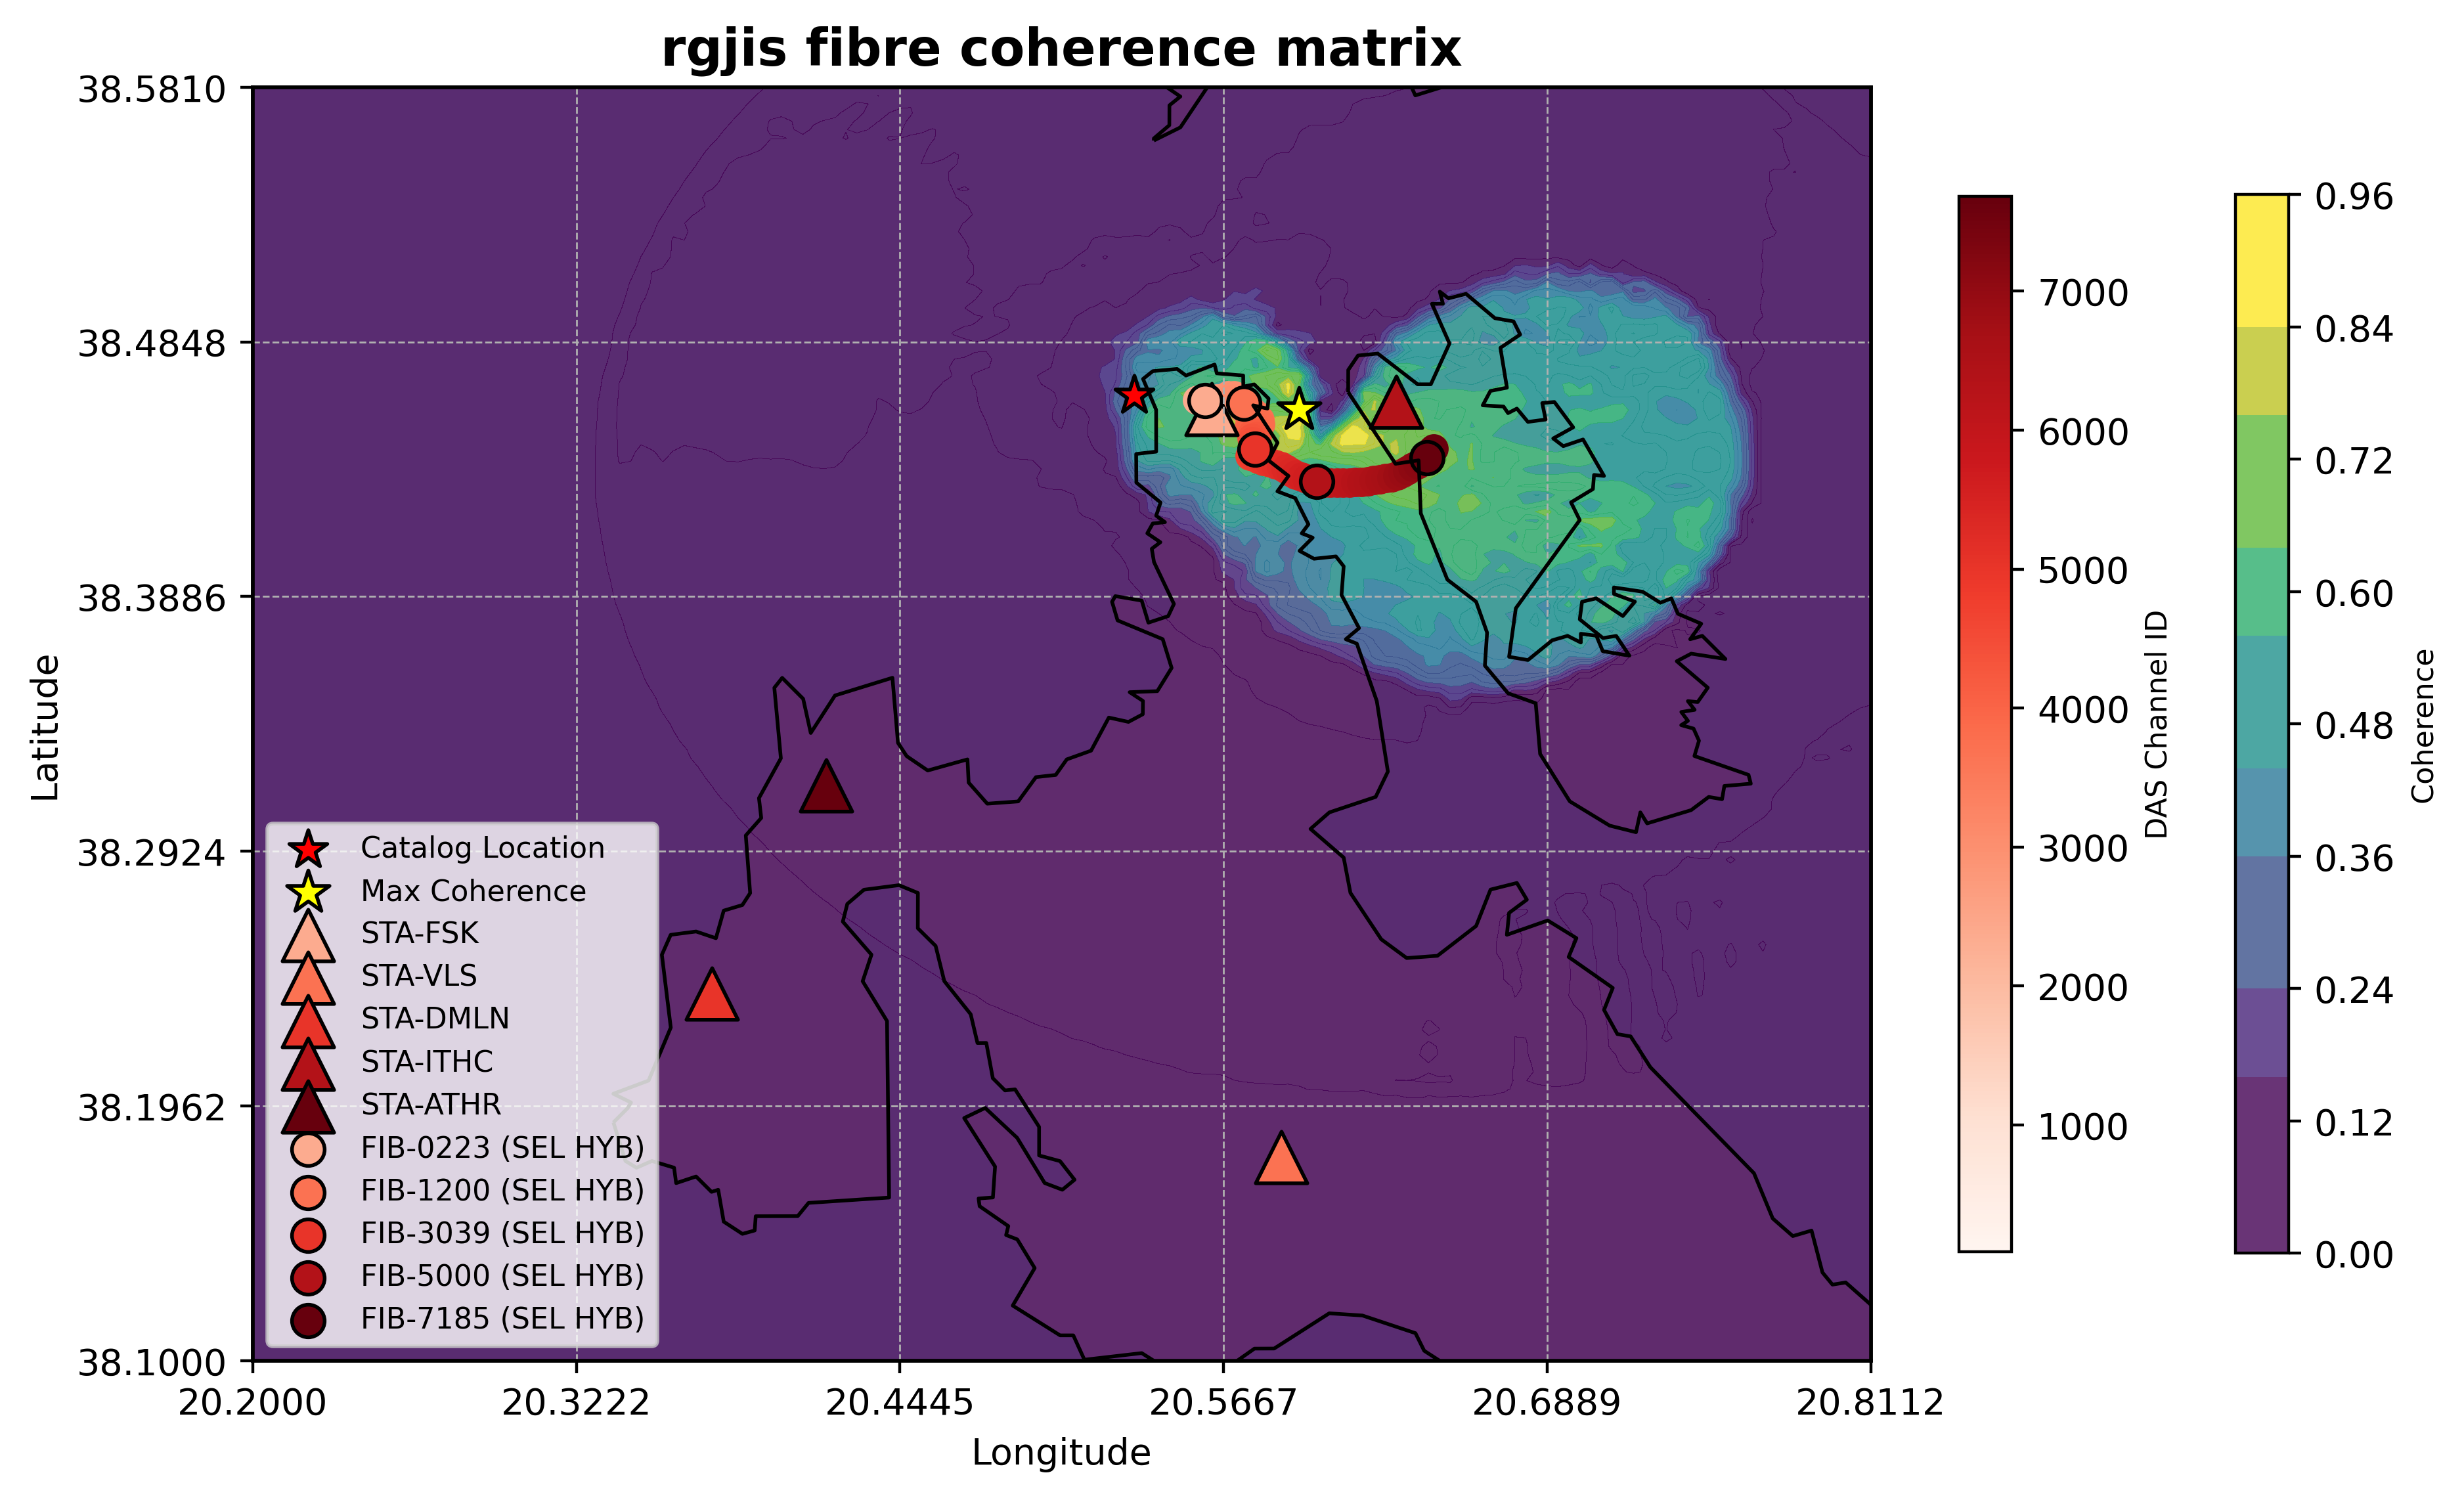

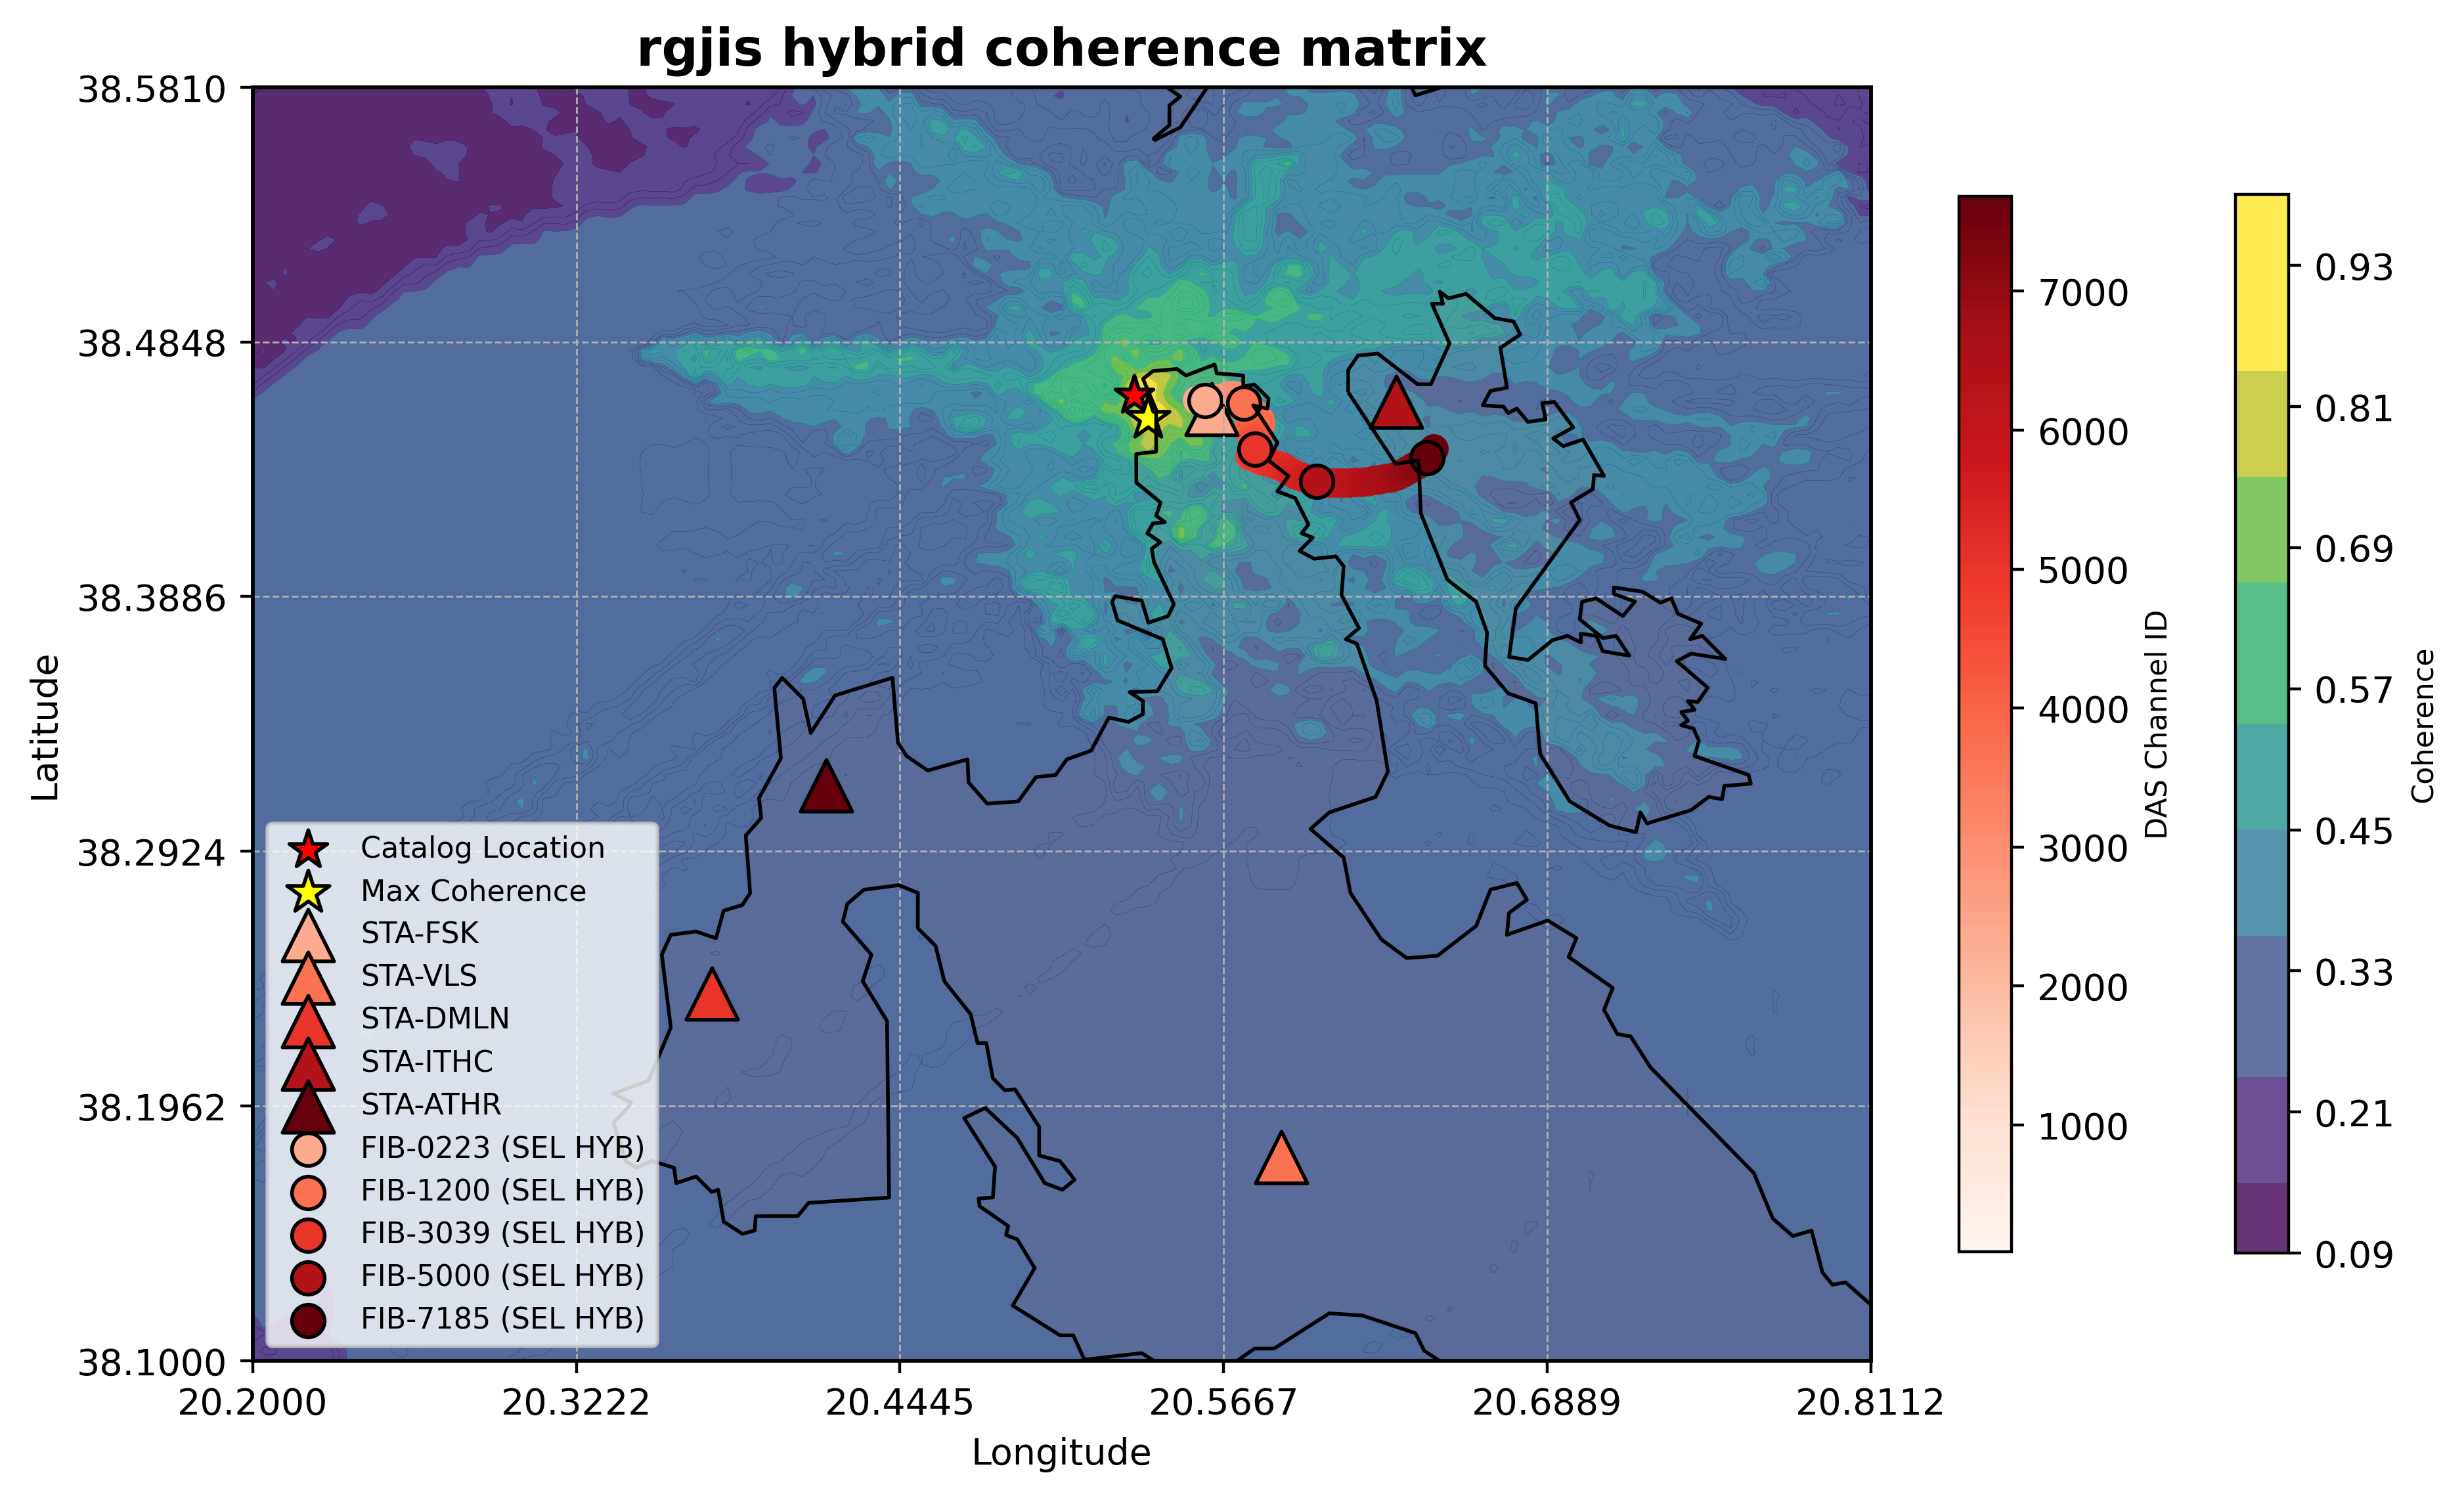

In [22]:
stations = {
    "STA-FSK": (38.4593, 20.5623),
    "STA-VLS": (38.17683, 20.5886),
    "STA-DMLN": (38.2385, 20.3734),
    "STA-ITHC": (38.4622, 20.6320),
    "STA-ATHR": (38.3172, 20.4165),
}

das_hyb = {
    "FIB-0223 (SEL HYB)": (38.4626, 20.5597),
    "FIB-1200 (SEL HYB)": (38.4616330270127,  20.5743533342759),
    "FIB-3039 (SEL HYB)": (38.4442, 20.5785),
    "FIB-5000 (SEL HYB)": (38.4319915392217 , 20.6018513810208) ,
    "FIB-7185 (SEL HYB)": (38.4410, 20.6435),

}

base_dir = "/home/emanuele/data/emanuele/loki-das/cefalonia/events"

geometry_das = "/home/emanuele/data/emanuele/loki-das/cefalonia/geometry/das_channels_edited.csv"

ref_lat = 38.10
ref_lon = 20.20

# Define name
name = "rgjis"
#name = "prlri"
#name = 'prefy'
#name = 'qalpq'
#name = 'pqvcv'
#name = 'qmbey'
#name = 'qsmcp'

earthquake_location = (38.4645, 20.533)    #rgjis
#earthquake_location = (38.2521, 20.5879)    #prlri
#earthquake_location = (38.3913, 20.4277)    #prefy
#earthquake_location = (38.5268, 20.5119)   #qalpq
#earthquake_location = (38.4196, 20.4515)  #pqvcv
#earthquake_location = (38.5519, 20.5344)  #qmbey
#earthquake_location = (38.2791, 20.4776)  #qsmcp

nx = 151 
ny = 151
nz = 151
dx = 0.5
dz = 0.5
ref_lat = 38.10
ref_lon = 20.20


# Loop to create paths

viridis_rgb = [
    [68, 1, 84], [71, 35, 122], [59, 81, 139], [44, 121, 153],
    [33, 145, 140], [45, 174, 109], [96, 186, 59], [189, 196, 36], [253, 231, 37]
]
viridis_rgb = np.array(viridis_rgb) / 255.0
viridis_cmap = mcolors.ListedColormap(viridis_rgb)
new_levels = 20
new_colors = viridis_cmap(np.linspace(0, 1, new_levels))
cmap = mcolors.ListedColormap(new_colors)
boundaries = np.linspace(0, 1, 21)
norm = mcolors.BoundaryNorm(boundaries, cmap.N)


files, titles, lat_range, lon_range = load_and_reshape_matrix(name, base_dir, ref_lat=ref_lat, ref_lon=ref_lon, dx=dx, dz=dz, nx=nx, ny=ny, nz=nz)

for i in range(3):
    corrmatrix_sta = np.load(files[i])
    corrmatrix_sta = np.reshape(corrmatrix_sta, (nx, ny, nz))
    cartesian_grid_x, cartesian_grid_y= np.meshgrid(np.linspace(0, 75.5, nx), np.linspace(0,75.5, ny))


    #plot_geographical_map_simple(
    #    ref_lat, ref_lon, stations, geometry_das, earthquake_location, corrmatrix_sta,
    #    cartesian_grid_x, cartesian_grid_y, lat_range, lon_range,
    #    title='Integrated seismic network', files=files[0], titles='Integrated seismic network'
    #)
    plot_geographical_map(ref_lat, ref_lon, stations, geometry_das, das_hyb, earthquake_location, corrmatrix_sta,
                    cartesian_grid_x, cartesian_grid_y, lat_range, lon_range,
                    title=titles[i], files=files[i], titles = titles[i])
    
    #plot_xz_yz_sections(corrmatrix_sta, cartesian_grid_x, cartesian_grid_z, cartesian_grid_y, cmap, norm)
    
    #load_das_channels(geometry_das)   
    



## 3D PLOTS 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import utm

# Convert to Cartesian coordinates relative to the reference station
def convert_to_cartesian(lat, lon, ref_lat, ref_lon):
    ref_east, ref_north, _, _ = utm.from_latlon(ref_lat, ref_lon)
    east, north, _, _ = utm.from_latlon(lat, lon)
    return (east - ref_east) / 1000, (north - ref_north) / 1000

def coherence_plot(corrmatrix, xax, yax, zax, itrial, earthquake_x, earthquake_y, earthquake_z, normalization=False, xlim=None, ylim=None, zlim=None):
    nx, ny, nz = np.shape(corrmatrix)
    CXY = np.zeros([ny, nx])
    CXZ = np.zeros([nz, nx])
    CYZ = np.zeros([nz, ny])

    for i in range(ny):
        for j in range(nx):
            CXY[i, j] = np.max(corrmatrix[j, i, :])

    for i in range(nz):
        for j in range(nx):
            CXZ[i, j] = np.max(corrmatrix[j, :, i])

    for i in range(nz):
        for j in range(ny):
            CYZ[i, j] = np.max(corrmatrix[:, j, i])

    if normalization:
        nrm = plt.Normalize(vmin=0, vmax=1)
    else:
        nrm = None

    fig, axs = plt.subplots(1, 3, figsize=(15, 7.5), dpi=400)
    fig.suptitle('Coherence Matrices LION (Fiber Network)', fontsize=20, fontweight='bold')
    cmap = plt.cm.get_cmap('viridis', 100)

    # XY Plot
    ax1 = axs[0]
    cs1 = ax1.contourf(xax, yax, CXY, 20, cmap=cmap, norm=nrm)
    ax1.set_xlabel('X (km)')
    ax1.set_ylabel('Y (km)')
    ax1.set_aspect('auto')
    ax1.scatter(earthquake_x, earthquake_y, color='red', marker='*', s=100, label='Earthquake')
    ax1.legend()
    if xlim:
        ax1.set_xlim(xlim)
    if ylim:
        ax1.set_ylim(ylim)

    # YZ Plot
    ax2 = axs[1]
    cs2 = ax2.contourf(yax, zax, CYZ, 20, cmap=cmap, norm=nrm)
    ax2.set_xlabel('Y (km)')
    ax2.set_ylabel('Z (km)')
    ax2.set_aspect('auto')
    ax2.invert_yaxis()
    ax2.scatter(earthquake_y, earthquake_z, color='red', marker='*', s=100, label='Earthquake')
    ax2.legend()
    if ylim:
        ax2.set_xlim(ylim)
    if zlim:
        ax2.set_ylim(zlim)

    # XZ Plot
    ax3 = axs[2]
    cs3 = ax3.contourf(xax, zax, CXZ, 20, cmap=cmap, norm=nrm)
    ax3.set_xlabel('X (km)')
    ax3.set_ylabel('Z (km)')
    ax3.set_aspect('auto')
    ax3.invert_yaxis()
    ax3.scatter(earthquake_x, earthquake_z, color='red', marker='*', s=100, label='Earthquake')
    ax3.legend()
    if xlim:
        ax3.set_xlim(xlim)
    if zlim:
        ax3.set_ylim(zlim)

    # Add colorbar
    cbar = plt.colorbar(cs1, ax=axs, orientation='horizontal', shrink=0.6)
    cbar.set_label('Coherence')

    plt.show()

# Example reference station
ref_lat, ref_lon = 38.1, 20.2  # Change to actual reference station

# Earthquake location
earthquake_lat, earthquake_lon = 38.2521, 20.5879
earthquake_x, earthquake_y = convert_to_cartesian(earthquake_lat, earthquake_lon, ref_lat, ref_lon)
earthquake_z = -19  # Example depth in km

print(earthquake_x, earthquake_y)


34.085785951553554 16.65443337166216


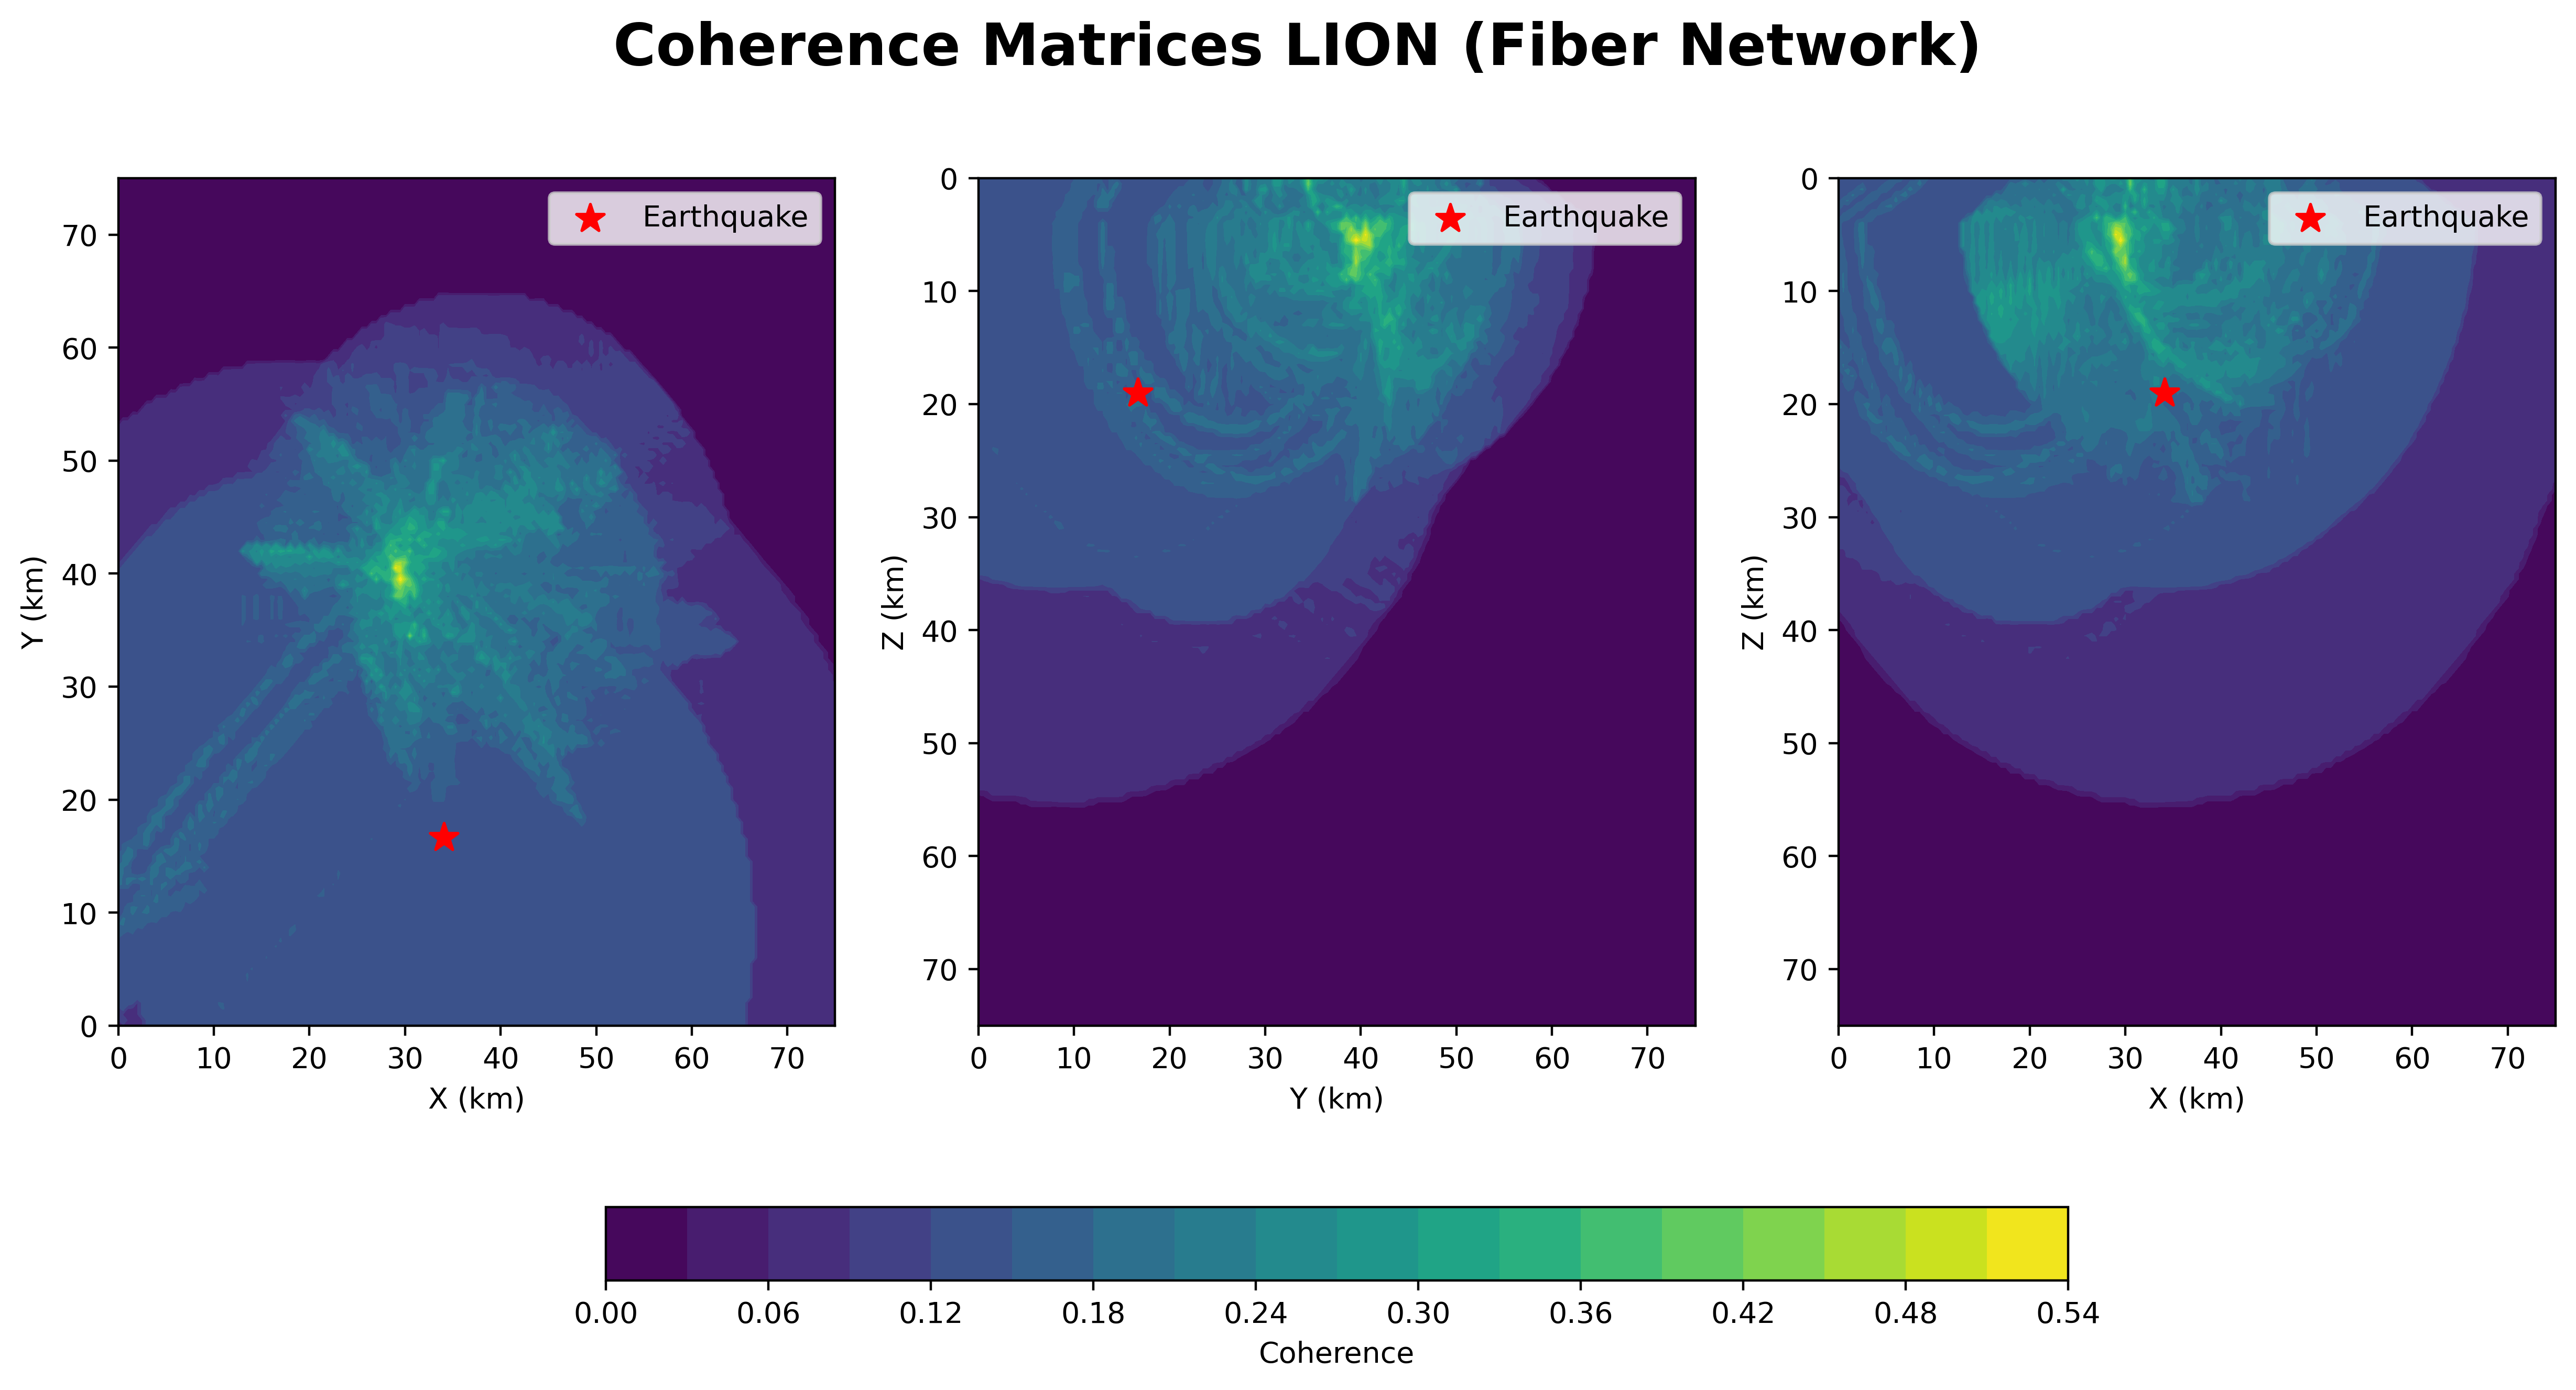

In [24]:


x =  np.arange(0, (nx * dx) , (dx))  #define the grid search based on the 2D traveltime grid
y =  np.arange(0, (nx * dx), (dx ))  #define the grid search based on the 2D traveltime grid
z =  np.arange(0, (nz * dz), dz) #define the grid search based on the 2D traveltime grid


coherence_plot(corrmatrix_sta, x, y, z, itrial=1, earthquake_x =34.085785951553554  , earthquake_y = 16.65443337166216  , earthquake_z = 19)

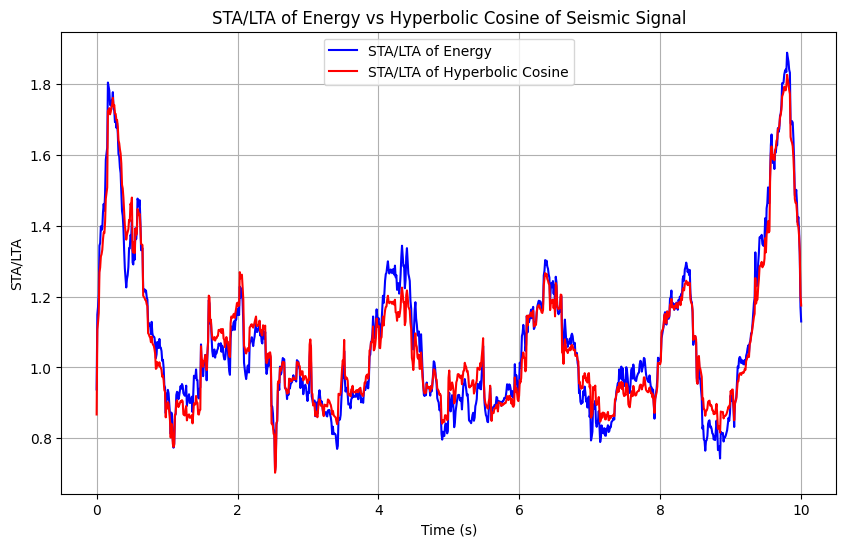

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate a seismic signal (e.g., sine wave with added noise)
t = np.linspace(0, 10, 1000)  # Time vector
signal = np.sin(2 * np.pi * t) + 0.5 * np.random.randn(len(t))  # Seismic signal with noise

# Calculate the energy of the seismic signal
energy = signal**2

# Compute the hyperbolic cosine of the signal
cosh_signal = np.cosh(signal)

# STA/LTA calculation function
def sta_lta(signal, short_window, long_window):
    sta = np.convolve(signal**2, np.ones(short_window)/short_window, mode='same')
    lta = np.convolve(signal**2, np.ones(long_window)/long_window, mode='same')
    return sta / lta

# Define window sizes for STA and LTA
short_window = 50  # Short-term window size (in samples)
long_window = 200  # Long-term window size (in samples)

# Compute STA/LTA for energy and hyperbolic cosine
sta_lta_energy = sta_lta(signal, short_window, long_window)
sta_lta_cosh = sta_lta(cosh_signal, short_window, long_window)

# Plot STA/LTA of energy vs hyperbolic cosine
plt.figure(figsize=(10, 6))
plt.plot(t, sta_lta_energy, label='STA/LTA of Energy', color='blue')
plt.plot(t, sta_lta_cosh, label='STA/LTA of Hyperbolic Cosine', color='red')
plt.title("STA/LTA of Energy vs Hyperbolic Cosine of Seismic Signal")
plt.xlabel("Time (s)")
plt.ylabel("STA/LTA")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
#path_tot = "/home/emanuele/data/emanuele/loki-das/Data/e0043.189.06_station_coherence_matrix.npy"
#path_sta = "/home/emanuele/data/emanuele/loki-das/Data/e0043.189.06_station_coherence_matrix.npy"
#path_ch = "/home/emanuele/data/emanuele/loki-das/Data/e0043.189.06_station_coherence_matrix.npy"

In [11]:
#path_tot = "/home/emanuele/data/emanuele/loki-das/Data/e0060.188.07_station_coherence_matrix.npy"
#path_sta = "/home/emanuele/data/emanuele/loki-das/Data/e0060.188.07_station_coherence_matrix.npy"
#path_ch = "/home/emanuele/data/emanuele/loki-das/Data/e0060.188.07_station_coherence_matrix.npy"

In [12]:
#path_tot = "/home/emanuele/data/emanuele/loki-das/Data/e0269.169.07_station_coherence_matrix.npy"
#path_sta = "/home/emanuele/data/emanuele/loki-das/Data/e0269.169.07_station_coherence_matrix.npy"
#path_ch = "/home/emanuele/data/emanuele/loki-das/Data/e0269.169.07_station_coherence_matrix.npy"

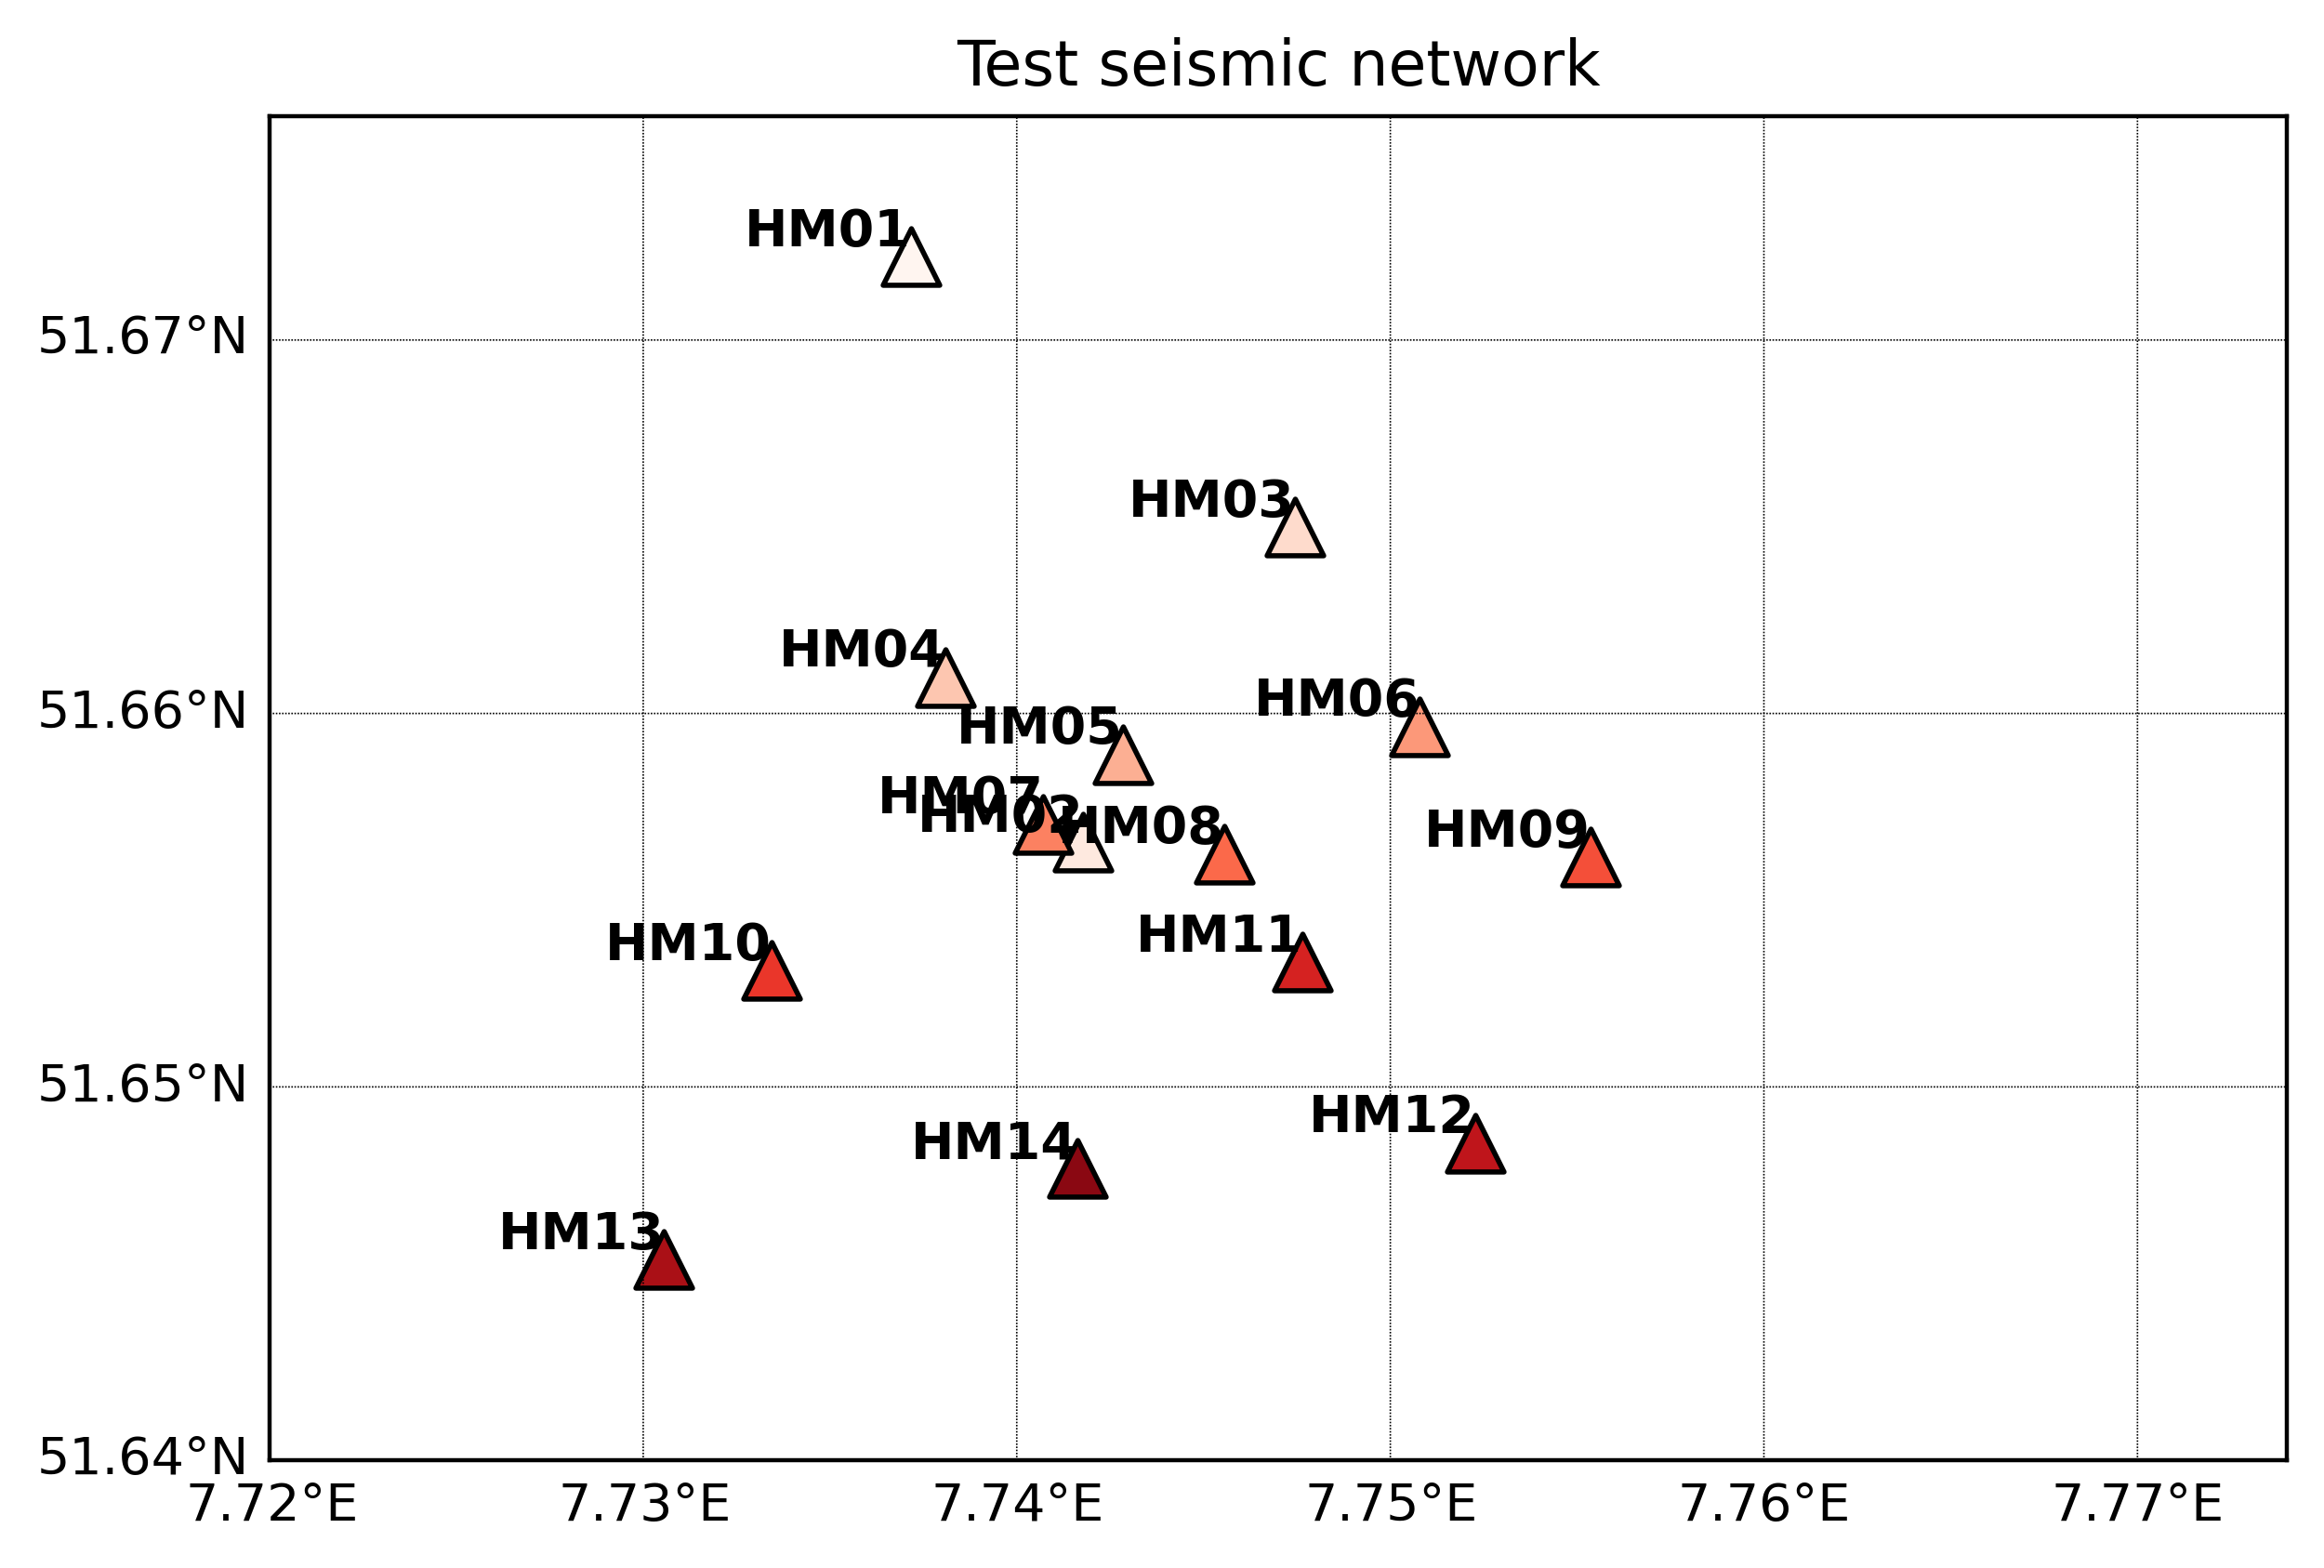

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.colors as mcolors

# Reference point
ref_lat, ref_lon = 51.64, 7.72
lat_extension, lon_extension = 0.036, 0.054  # Approximate degree equivalents for 4 km

# Compute bounding box
lat_min, lat_max = ref_lat , ref_lat + lat_extension
lon_min, lon_max = ref_lon , ref_lon + lon_extension

# Define seismic stations with coordinates
stations = {
    "HM01": (51.67223, 7.73717), "HM02": (51.65656, 7.74178), "HM03": (51.66499, 7.74745),
    "HM04": (51.66097, 7.73808), "HM05": (51.65890, 7.74283), "HM06": (51.65965, 7.75079),
    "HM07": (51.65704, 7.74071), "HM08": (51.65624, 7.74555), "HM09": (51.65616, 7.75536),
    "HM10": (51.65312, 7.73344), "HM11": (51.65334, 7.74765), "HM12": (51.64850, 7.75228),
    "HM13": (51.64538, 7.73056), "HM14": (51.64781, 7.74162)
}

# Filter stations within the defined boundary
filtered_stations = {name: (lat, lon) for name, (lat, lon) in stations.items()
                     if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max}

# Create a Basemap instance with higher resolution
plt.figure(figsize=(7,7), dpi = 400)
m = Basemap(projection='cyl', llcrnrlat=lat_min, urcrnrlat=lat_max, 
            llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='h')

# Draw map details with more features
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawrivers(color='blue', linewidth=0.7)
m.drawparallels(np.arange(lat_min, lat_max, 0.01), labels=[1, 0, 0, 0], linewidth=0.3)
m.drawmeridians(np.arange(lon_min, lon_max, 0.01), labels=[0, 0, 0, 1], linewidth=0.3)

# Add detailed elevation (shaded relief) data
#m.shadedrelief()

# Plot seismic stations within the boundary
cmap = plt.get_cmap("Reds")
norm = mcolors.Normalize(vmin=0, vmax=len(filtered_stations))
for i, (name, (lat, lon)) in enumerate(filtered_stations.items()):
    x, y = m(lon, lat)
    m.scatter(x, y, marker='^', color=cmap(norm(i)), s=120, edgecolors='black', label=name)
    plt.text(x, y, name, fontsize=10, ha='right', va='bottom', color='black', fontweight='bold')

plt.title("Test seismic network")
#plt.legend(loc='upper left', fontsize='small', frameon=True, title="Seismic Stations")
plt.show()


In [14]:
stations = {

"HM01": (51.67223, 7.73717),
"HM02": (51.65656, 7.74178),
"HM03": (51.66499, 7.74745),
"HM04": (51.66097, 7.73808),
"HM05": (51.65890, 7.74283),
"HM06": (51.65965, 7.75079),
"HM07": (51.65704, 7.74071),
"HM08": (51.65624, 7.74555),
"HM09": (51.65616, 7.75536),
"HM10": (51.65312, 7.73344),
"HM11": (51.65334, 7.74765),
"HM12": (51.64850, 7.75228),
"HM13": (51.64538, 7.73056),
"HM14": (51.64781, 7.74162),
"HM20": (51.65312, 7.73344),

}

das = {
"HM20": (51.65312, 7.73344),
}
earthquake_location = (0,0)

ref_lat = 51.64
ref_lon=7.72


nx = 151
ny = 151
nz = 151

dz = 0.05
dx = 0.05

km_to_deg = (nx*dx)/np.sqrt(2) / 111
km_to_deg_lon = (nx*dx)/np.sqrt(2)/ (111 * math.cos(math.radians(ref_lat))) 
lat_range = (ref_lat, ref_lat + km_to_deg)
lon_range = (ref_lon, ref_lon + km_to_deg_lon)


title = 'Test'

steps = 0.01


corrmatrix_tot = np.load(path_tot)
corrmatrix_sta = np.load(path_sta)
corrmatrix_ch = np.load(path_ch)

print(corrmatrix_sta.shape)



corrmatrix_sta = np.reshape(corrmatrix_sta,(nx,ny,nz))


NameError: name 'path_tot' is not defined

In [ ]:
cartesian_grid_x, cartesian_grid_y = np.meshgrid(np.linspace(0, 75.5, nx), np.linspace(0,75.5, ny))

plot_geographical_map(stations, das, earthquake_location, corrmatrix_sta,
                      cartesian_grid_x, cartesian_grid_y, lat_range, lon_range,
                      title=title)

TypeError: plot_geographical_map() missing 4 required positional arguments: 'lat_range', 'lon_range', 'files', and 'titles'

In [ ]:
nx, ny, nz = np.shape(corrmatrix_sta)
CXY = np.zeros([ny, nx])
CXZ = np.zeros([nz, nx])
CYZ = np.zeros([nz, ny])

for i in range(ny):
    for j in range(nx):
        CXY[i, j] = np.max(corrmatrix_sta[j, i, :])

for i in range(nz):
    for j in range(nx):
        CXZ[i, j] = np.max(corrmatrix_sta[j, :, i])

for i in range(nz):
    for j in range(ny):
        CYZ[i, j] = np.max(corrmatrix_sta[:, j, i])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors

def plot_geographical_map_complete(stations, das, earthquake_location, corrmatrix_sta, 
                           lat_range=None, lon_range=None, 
                           nx=None, ny=None, nz=None, dz=None, title="Geographical Map with Correlation"):
    """
    Plots a geographical map with stations, DAS locations, earthquake location, and correlation overlay.
    Also plots XZ and YZ coherence maps as subplots using a depth-based representation.
    """
    # Extract correlation matrix dimensions
    nx, ny, nz = np.shape(corrmatrix_sta)
    CXY = np.zeros([ny, nx])
    CXZ = np.zeros([nz, nx])
    CYZ = np.zeros([nz, ny])

    # Compute coherence for X-Y plane (CXY)
    for i in range(ny):
        for j in range(nx):
            CXY[i, j] = np.max(corrmatrix_sta[j, i, :])

    # Compute coherence for X-Z plane (CXZ)
    for i in range(nz):
        for j in range(nx):
            CXZ[i, j] = np.max(corrmatrix_sta[j, :, i])

    # Compute coherence for Y-Z plane (CYZ)
    for i in range(nz):
        for j in range(ny):
            CYZ[i, j] = np.max(corrmatrix_sta[:, j, i])

    # Find the location of the maximum correlation for CXY
    max_corr_index = np.unravel_index(np.argmax(CXY), CXY.shape)
    max_corr_lat = np.linspace(lat_range[0], lat_range[1], ny)[max_corr_index[0]]
    max_corr_lon = np.linspace(lon_range[0], lon_range[1], nx)[max_corr_index[1]]

    # Create the figure with subplots for map and coherence plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 10), dpi=400)  # Increased width to make space for legend

    # Plot geographical map on the first axis
    ax = axes[0]
    m = Basemap(projection='cyl', llcrnrlat=lat_range[0], urcrnrlat=lat_range[1],
                llcrnrlon=lon_range[0], urcrnrlon=lon_range[1], resolution='h', ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawrivers(color='blue', linewidth=0.5)
    m.fillcontinents(color='lightgray', lake_color='lightblue')
    m.drawmapboundary(fill_color='lightblue')
    m.drawparallels(np.arange(lat_range[0], lat_range[1], 0.01), labels=[1, 0, 0, 0], fontsize=8, linewidth=0.3)
    m.drawmeridians(np.arange(lon_range[0], lon_range[1], 0.01), labels=[0, 0, 0, 1], fontsize=8, linewidth=0.3)

    # Overlay correlation data
    X, Y = np.meshgrid(np.linspace(lon_range[0], lon_range[1], nx), np.linspace(lat_range[0], lat_range[1], ny))
    cs = ax.contourf(X, Y, CXY, 30, cmap='viridis', alpha=0.7)
    cbar = plt.colorbar(cs, ax=ax, label='Coherence', location='bottom', pad=0.05, fraction=0.04)
    cbar.ax.tick_params(labelsize=8)
    
    # Plot earthquake location
    red_star_lat, red_star_lon = earthquake_location
    ax.scatter(red_star_lon, red_star_lat, marker='*', color='red', edgecolors='black', s=120, label='Earthquake Location')

    # Create colormap for stations (shades of orange) and fibers (shades of blue)
    station_colors = plt.cm.Reds(np.linspace(0, 1, len(stations)))
    das_colors = plt.cm.Blues(np.linspace(0, 1, len(das)))

    # Plot stations with shades of orange
    for idx, (key, (lat, lon)) in enumerate(stations.items()):
        ax.scatter(lon, lat, marker='^', color=station_colors[idx], edgecolors='black', s=80, label=key)

    # Plot DAS with shades of blue
    for idx, (key, (lat, lon)) in enumerate(das.items()):
        ax.scatter(lon, lat, marker='o', color=das_colors[idx], edgecolors='black', s=60, label=key)

    # Plot the dark red circle where the correlation is maximum
    x, y = m(max_corr_lon, max_corr_lat)  # Convert to map projection coordinates
    ax.scatter(x, y, marker='o', color='gold', edgecolors='black', s=150, label='Max Correlation Point')
    
    # Place the legend outside the first plot (on the right side of the figure)
    ax.legend(loc='center left', bbox_to_anchor=(0.3, 1.5), fontsize=10, title="Legend", title_fontsize=12)
    ax.set_title(f'{title} - Geographical Map', fontsize=14, fontweight='bold')

    # Create a consistent grid for all three plots
    depth_range = np.linspace(0, dz * nz, nz)  # Depth axis for XZ and YZ
    X, Y = np.meshgrid(np.linspace(lon_range[0], lon_range[1], nx), depth_range)

    # Plot XZ coherence map on the second axis
    ax = axes[1]
    XZ = ax.contourf(np.linspace(lon_range[0], lon_range[1], nx), depth_range, CXZ, 30, cmap='viridis', alpha=0.7)
    cbar = plt.colorbar(XZ, ax=ax, label='Coherence', location='bottom', pad=0.05, fraction=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f'{title} - XZ Coherence', fontsize=14, fontweight='bold')
    ax.set_ylabel('Depth (km)', fontsize=12)
    ax.invert_yaxis()

    # Plot YZ coherence map on the third axis
    ax = axes[2]
    YZ = ax.contourf(np.linspace(lon_range[0], lon_range[1], ny), depth_range, CYZ, 30, cmap='viridis', alpha=0.7)
    cbar = plt.colorbar(YZ, ax=ax, label='Coherence', location='bottom', pad=0.05, fraction=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f'{title} - YZ Coherence', fontsize=14, fontweight='bold')
    ax.set_ylabel('Depth (km)', fontsize=12)
    ax.invert_yaxis()

    # Plot stations and fibers on XZ and YZ coherence maps
    for idx, (key, (lat, lon)) in enumerate(stations.items()):
        # Plot station on XZ map (based on depth, assuming a constant depth for each station)
        depth_position = 0  # Modify this based on the actual depth data
        ax = axes[1]
        ax.scatter(lon, depth_position, marker='^', color=station_colors[idx], edgecolors='black', s=80)

        # Plot station on YZ map
        ax = axes[2]
        ax.scatter(lon, depth_position, marker='^', color=station_colors[idx], edgecolors='black', s=80)

    for idx, (key, (lat, lon)) in enumerate(das.items()):
        # Plot DAS on XZ map
        depth_position = 0  # Modify this based on the actual depth data
        ax = axes[1]
        ax.scatter(lon, depth_position, marker='o', color=das_colors[idx], edgecolors='black', s=60)

        # Plot DAS on YZ map
        ax = axes[2]
        ax.scatter(lon, depth_position, marker='o', color=das_colors[idx], edgecolors='black', s=60)

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right side for the legend
    plt.show()

# Example usage:
plot_geographical_map_complete(stations, das, earthquake_location, corrmatrix_sta, lat_range=lat_range, lon_range=lon_range, nx=nx, ny=ny, nz=nz, dz = dz, title=title)


NameError: name 'title' is not defined

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import utm

# Convert to Cartesian coordinates relative to the reference station
def convert_to_cartesian(lat, lon, ref_lat, ref_lon):
    ref_east, ref_north, _, _ = utm.from_latlon(ref_lat, ref_lon)
    east, north, _, _ = utm.from_latlon(lat, lon)
    return (east - ref_east) / 1000, (north - ref_north) / 1000

def coherence_plot(corrmatrix, xax, yax, zax, itrial, earthquake_x, earthquake_y, earthquake_z, normalization=False, xlim=None, ylim=None, zlim=None):
    nx, ny, nz = np.shape(corrmatrix)
    CXY = np.zeros([ny, nx])
    CXZ = np.zeros([nz, nx])
    CYZ = np.zeros([nz, ny])

    for i in range(ny):
        for j in range(nx):
            CXY[i, j] = np.max(corrmatrix[j, i, :])

    for i in range(nz):
        for j in range(nx):
            CXZ[i, j] = np.max(corrmatrix[j, :, i])

    for i in range(nz):
        for j in range(ny):
            CYZ[i, j] = np.max(corrmatrix[:, j, i])

    if normalization:
        nrm = plt.Normalize(vmin=0, vmax=1)
    else:
        nrm = None

    fig, axs = plt.subplots(1, 3, figsize=(15, 7.5), dpi=400)
    fig.suptitle('Coherence Matrices LION (Fiber Network)', fontsize=20, fontweight='bold')
    cmap = plt.cm.get_cmap('viridis', 100)

    # XY Plot
    ax1 = axs[0]
    cs1 = ax1.contourf(xax, yax, CXY, 20, cmap=cmap, norm=nrm)
    ax1.set_xlabel('X (km)')
    ax1.set_ylabel('Y (km)')
    ax1.set_aspect('auto')
    ax1.scatter(earthquake_x, earthquake_y, color='red', marker='*', s=100, label='Earthquake')
    ax1.legend()
    if xlim:
        ax1.set_xlim(xlim)
    if ylim:
        ax1.set_ylim(ylim)

    # YZ Plot
    ax2 = axs[1]
    cs2 = ax2.contourf(yax, zax, CYZ, 20, cmap=cmap, norm=nrm)
    ax2.set_xlabel('Y (km)')
    ax2.set_ylabel('Z (km)')
    ax2.set_aspect('auto')
    ax2.invert_yaxis()
    ax2.scatter(earthquake_y, earthquake_z, color='red', marker='*', s=100, label='Earthquake')
    ax2.legend()
    if ylim:
        ax2.set_xlim(ylim)
    if zlim:
        ax2.set_ylim(zlim)

    # XZ Plot
    ax3 = axs[2]
    cs3 = ax3.contourf(xax, zax, CXZ, 20, cmap=cmap, norm=nrm)
    ax3.set_xlabel('X (km)')
    ax3.set_ylabel('Z (km)')
    ax3.set_aspect('auto')
    ax3.invert_yaxis()
    ax3.scatter(earthquake_x, earthquake_z, color='red', marker='*', s=100, label='Earthquake')
    ax3.legend()
    if xlim:
        ax3.set_xlim(xlim)
    if zlim:
        ax3.set_ylim(zlim)

    # Add colorbar
    cbar = plt.colorbar(cs1, ax=axs, orientation='horizontal', shrink=0.6)
    cbar.set_label('Coherence')

    plt.show()

# Example reference station
ref_lat, ref_lon = 38.1, 20.2  # Change to actual reference station

# Earthquake location
earthquake_lat, earthquake_lon = 38.2521, 20.5879
earthquake_x, earthquake_y = convert_to_cartesian(earthquake_lat, earthquake_lon, ref_lat, ref_lon)
earthquake_z = -19  # Example depth in km

print(earthquake_x, earthquake_y)


34.085785951553554 16.65443337166216


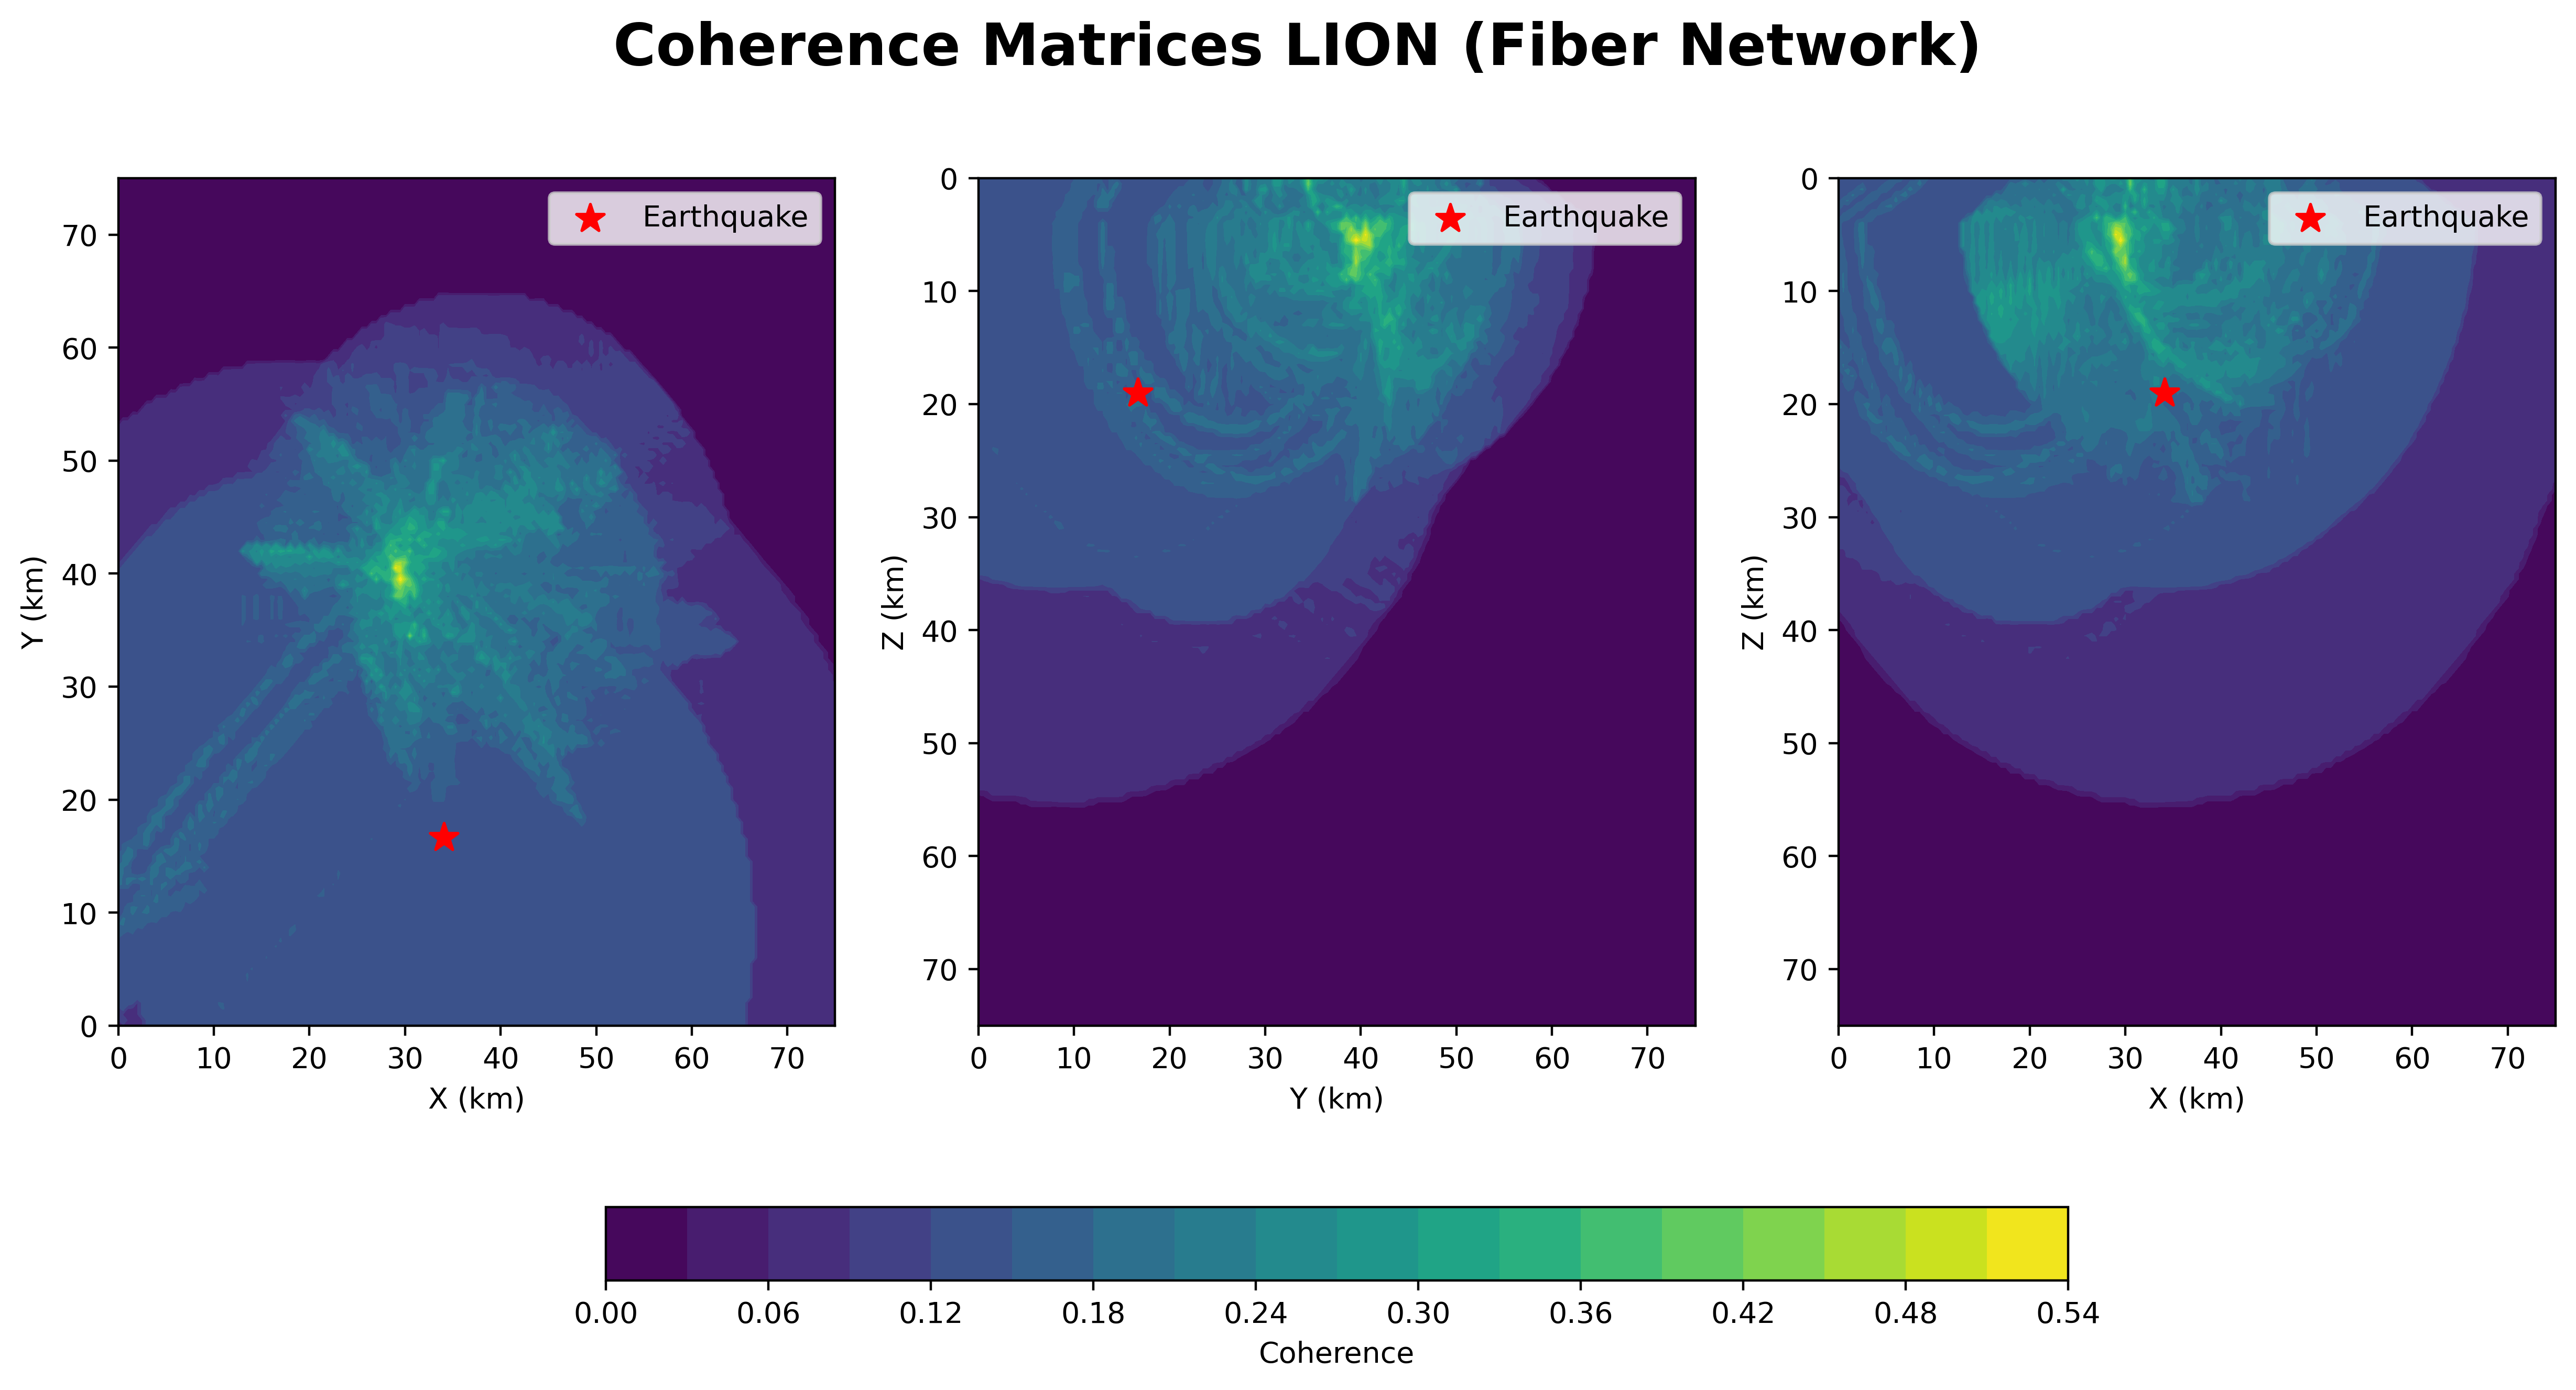

import numpy as np
import matplotlib.pyplot as plt

# Grid parameters
nx, ny, nz = 101, 101, 101  # Number of points in each direction (X, Y, Z)
dx, dy, dz = 0.05/np.sqrt(2), 0.05/np.sqrt(2), 0.05/np.sqrt(2)  # Grid spacing (X, Y, Z)

# Define X, Y, Z ranges starting from (0, 0) at the corner
x = np.linspace(0, (dx * (nx - 1)), nx)  # X values (longitude), starting from 0
y = np.linspace(0, (dy * (ny - 1)), ny)  # Y values (latitude), starting from 0
z = np.linspace(0, ((nz - 1) * dz), nz)  # Z values (depth)

# Reverse the Z values to ensure depth=0 is at the top and increasing depth goes downward
z = z[::-1]

# Create the meshgrid (X, Y, Z)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

print(X.shape, X.ravel().shape)

# Flatten the meshgrid to 1D arrays
lon_source = X.ravel()  # Flatten X values (longitude)
lat_source = Y.ravel()  # Flatten Y values (latitude)
depth_source = Z.ravel()  # Flatten Z values (depth)

# Reduce the number of grid points (downsample by selecting every nth point)
n = 710  # Factor by which to downsample (adjust as needed)
lon_source = lon_source[::n]
lat_source = lat_source[::n]
depth_source = depth_source[::n]

# Station coordinates (replace with your actual station data)
stations = [
    ("HM01", 3.223, 1.717, 0.0),
    ("HM02", 1.656, 2.178, 0.0),
    ("HM03", 2.499, 2.745, 0.0),
    ("HM04", 2.097, 1.808, 0.0),
    ("HM05", 1.890, 2.283, 0.0),
    ("HM06", 1.965, 3.079, 0.0),
    ("HM07", 1.704, 2.071, 0.0),
    ("HM08", 1.624, 2.555, 0.0),
    ("HM09", 1.616, 3.536, 0.0),
    ("HM10", 1.312, 1.344, 0.0),
    ("HM11", 1.334, 2.765, 0.0),
    ("HM12", 0.850, 3.228, 0.0),
    ("HM13", 0.538, 1.056, 0.0),
    ("HM14", 0.781, 2.162, 0.0),
    ("HM20", 1.312, 1.344, 0.0),
]

# Extract the station coordinates
station_lons = [s[1] for s in stations]
station_lats = [s[2] for s in stations]
station_depths = [s[3] for s in stations]

# Plot the grid points in 3D
fig = plt.figure(figsize=(10, 10), dpi = 400)
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the reduced grid points with transparency
sc = ax.scatter(lon_source, lat_source, depth_source, c=lat_source, cmap='viridis', s=50, alpha=0.3)

# Scatter plot for the stations as red triangles (plot after the grid points to ensure they are on top)
ax.scatter(station_lons, station_lats, station_depths, color='red', marker='^', s=150, label="Stations", alpha=1)

# Diagonal rectangle extending vertically from (0, 0, 0) to the opposite corner of the cube
# We will define a diagonal along the Z axis, and extend it along the plane diagonal.
max_x = dx * (nx - 1)
max_y = dy * (ny - 1)
max_z = dz * (nz - 1)

# Define the four corners of the rectangle
x_rect = [0, max_x]
y_rect = [0, max_y]
z_rect = [0, max_z]

# Generate points for the vertical rectangle that extends along the diagonal of the cube
rect_x = np.array([0, 0, max_x, max_x, 0])
rect_y = np.array([0, 0, max_y, max_y, 0])
rect_z = np.array([0, max_z, max_z, 0, 0])

# Plot the rectangle in 3D space along the diagonal
ax.plot(rect_x, rect_y, rect_z, color='orange', linewidth=2, label="2D traveltime lookup table")

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Latitude grid Value")

# Set Z-axis limits manually to ensure 0 is at the top (invert the Z-axis)
ax.set_zlim([np.max(depth_source), np.min(depth_source)])

# Labels
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [Km]')
ax.set_zlabel('Z [Km]')
ax.set_title('LION')

# Show legend for stations
ax.legend()

# Show the plot
plt.show()
